In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Download CO2 data from NOAA
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'

names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(url, skiprows=72, names=names, index_col=False)

In [3]:
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1960,10,1960.7896,313.83,316.83,-1,-9.99,-0.99
1,1960,11,1960.8743,315.00,316.88,-1,-9.99,-0.99
2,1960,12,1960.9563,316.19,316.96,-1,-9.99,-0.99
3,1961,1,1961.0411,316.89,316.86,-1,-9.99,-0.99
4,1961,2,1961.1260,317.70,317.08,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
754,2023,8,2023.6250,419.68,421.57,21,0.45,0.19
755,2023,9,2023.7083,418.51,421.96,18,0.30,0.14
756,2023,10,2023.7917,418.82,422.11,27,0.47,0.17
757,2023,11,2023.8750,420.46,422.43,21,0.91,0.38


In [4]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

<Axes: title={'center': 'CO2 Levels at Mauna Loa Observatory'}>

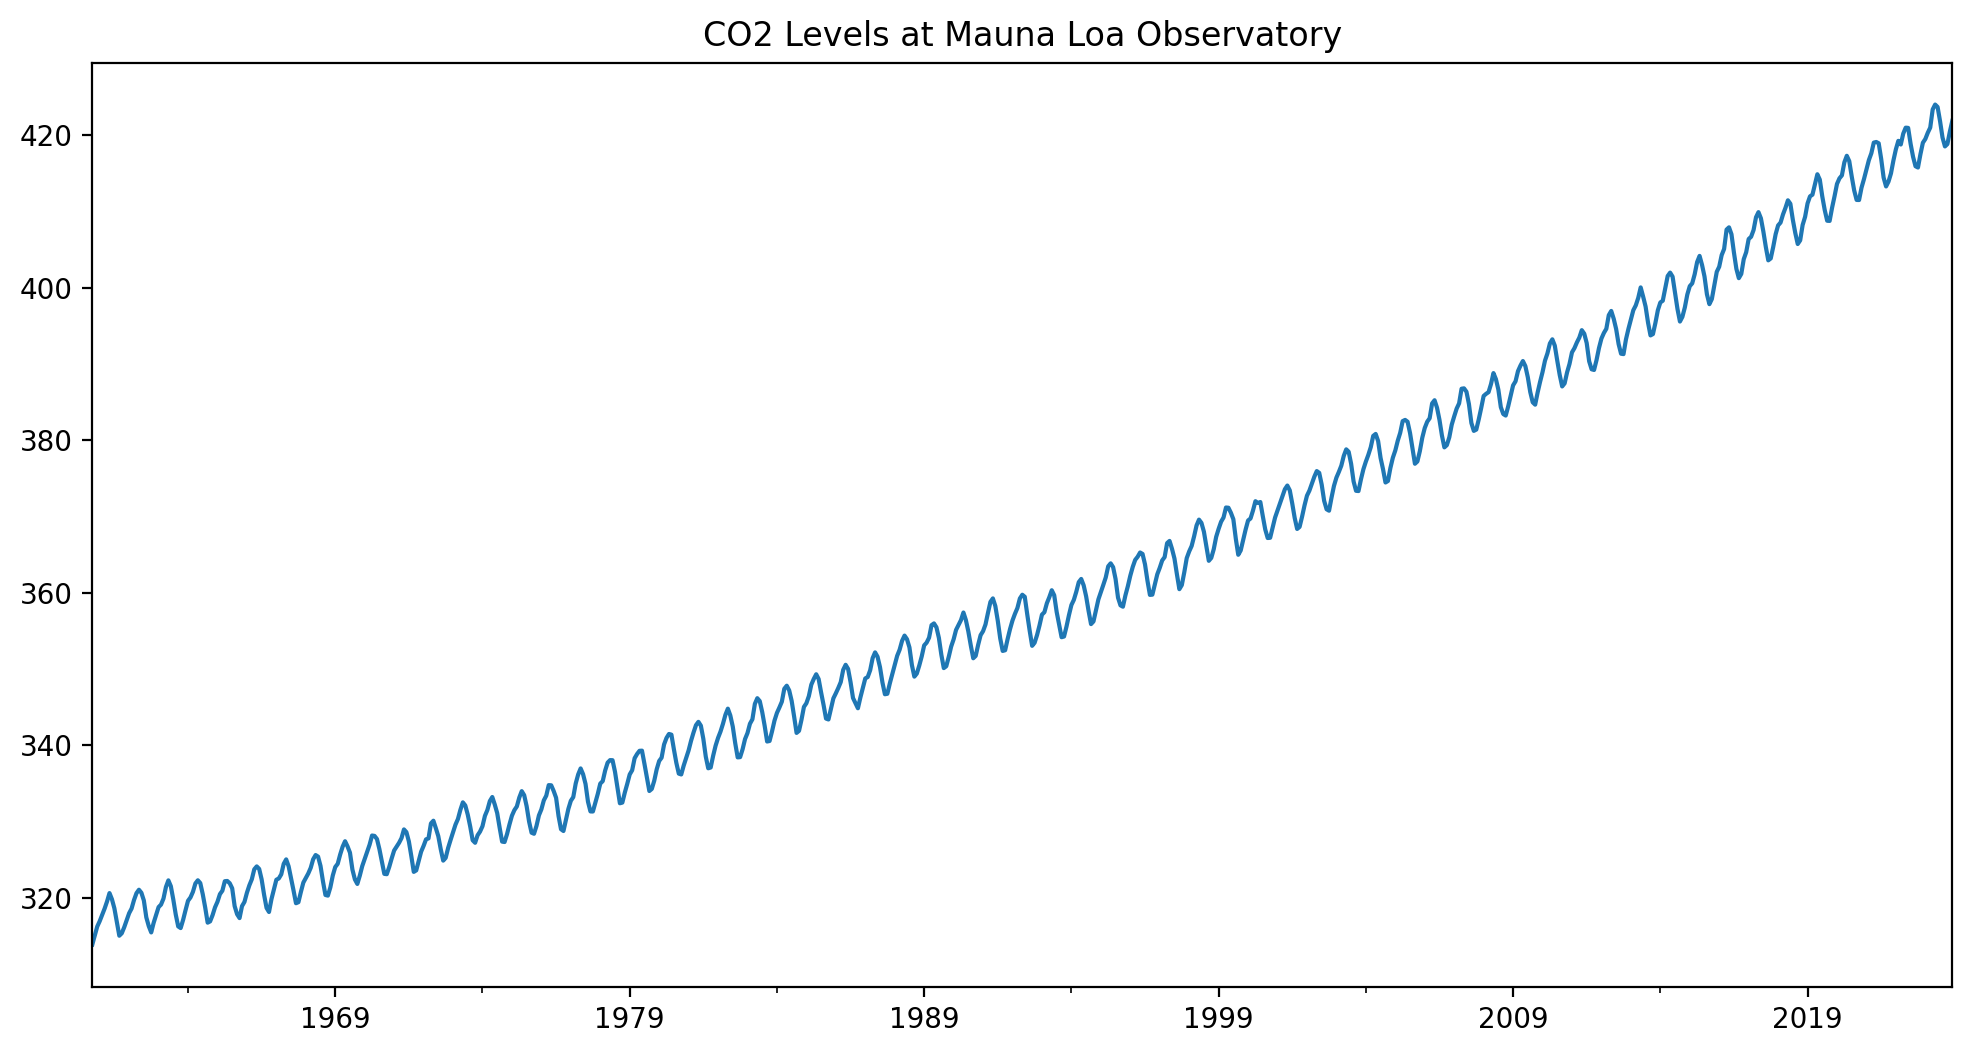

In [5]:
df.average.plot(figsize=(12, 6), title='CO2 Levels at Mauna Loa Observatory')

In [6]:
# Create X and y

# X = months since first measurement
X = np.array(range(len(df)))
y = df.average.values

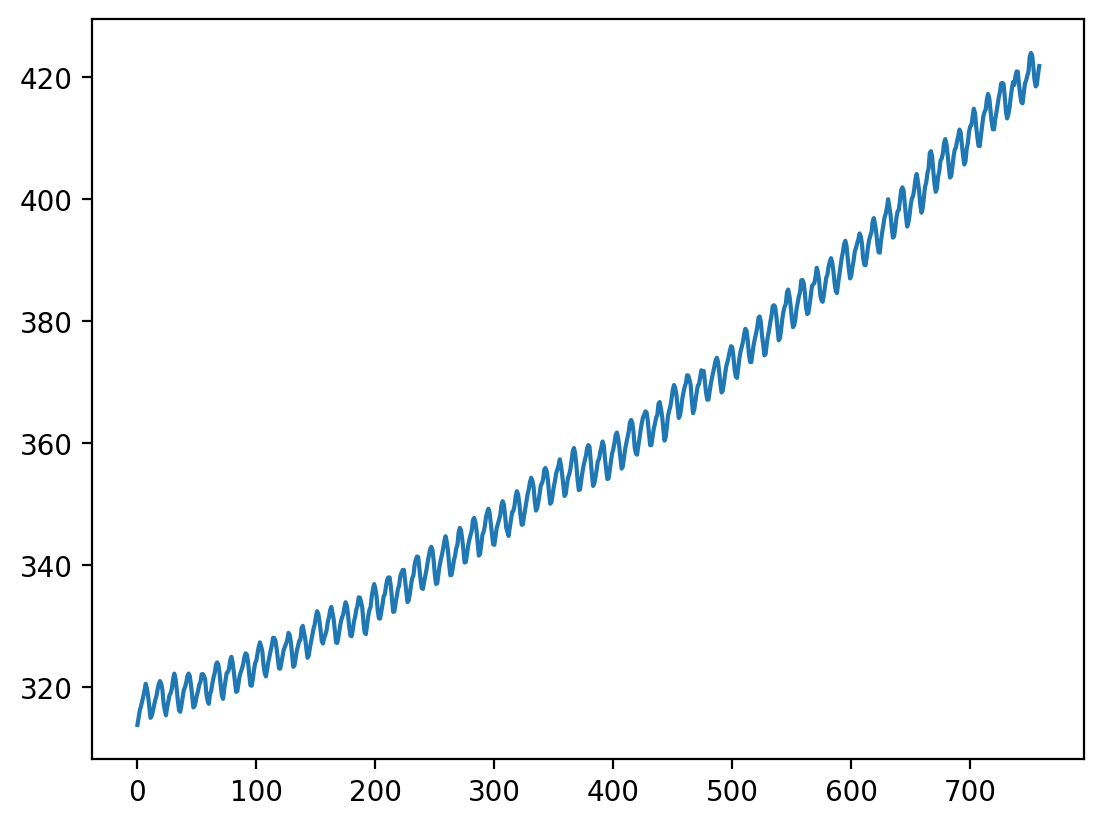

In [7]:
plt.plot(X, y)

In [8]:
# Normalize X and y

s1 = StandardScaler()
s2 = StandardScaler()

X_norm = s1.fit_transform(X.reshape(-1, 1))
y_norm = s2.fit_transform(y.reshape(-1, 1))

In [9]:
X_norm.mean(), X_norm.std()

(0.0, 1.0)

In [10]:
y_norm.mean(), y_norm.std()

(1.647635329298783e-15, 1.0)

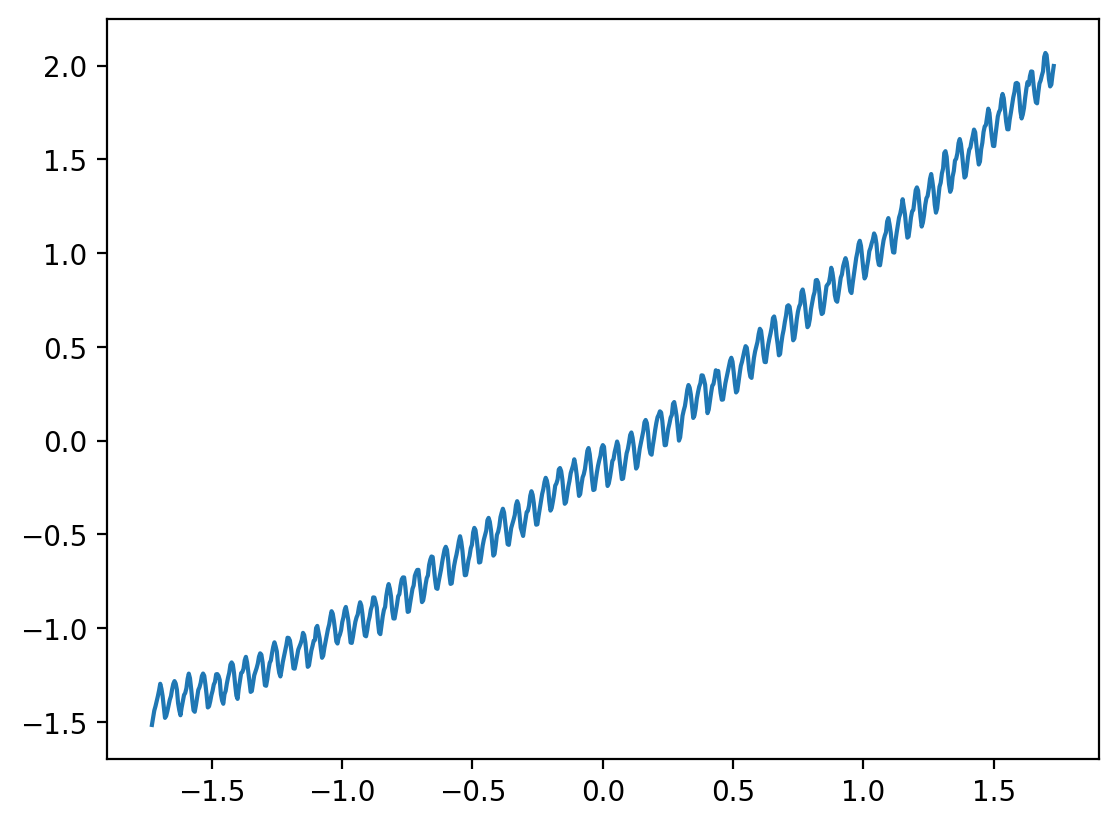

In [11]:
plt.plot(X_norm, y_norm)

#### Task 1: Interpolation

In [12]:
np.random.seed(42)
train_idx = np.random.choice(range(len(X_norm)), size=int(len(X_norm) * 0.7), replace=False)
test_idx = list(set(range(len(X_norm))) - set(train_idx))

X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

X_norm_train = X_norm[train_idx]
y_norm_train = y_norm[train_idx]

X_norm_test = X_norm[test_idx]
y_norm_test = y_norm[test_idx]

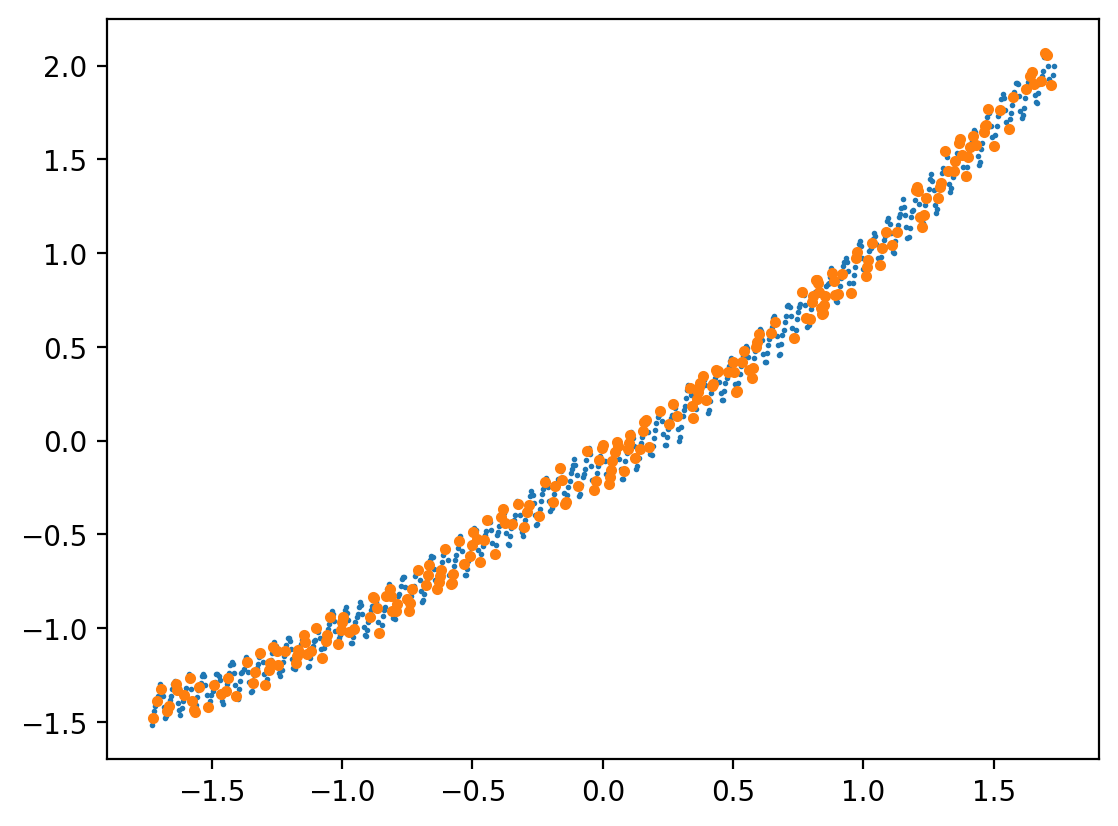

In [13]:
plt.plot(X_norm_train, y_norm_train, 'o', label='train',markersize=1)
plt.plot(X_norm_test, y_norm_test, 'o', label='test', ms=3)

In [14]:
errors= {}
X_lin_1d = np.linspace(X_norm.min(), X_norm.max(), 100).reshape(-1, 1)

### Model 1: Vanilla Linear Regression

In [15]:
def plot_fit_predict(model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin, title, plot=True):
    model.fit(X_norm_train, y_norm_train)

    y_hat_train = model.predict(X_norm_train).reshape(-1, 1)
    y_hat_test = model.predict(X_norm_test).reshape(-1, 1)

    # Transform back to original scale
    y_hat_train = s2.inverse_transform(y_hat_train)
    y_hat_test = s2.inverse_transform(y_hat_test)

    y_hat_lin = s2.inverse_transform(model.predict(X_lin).reshape(-1, 1))

    errors[title] = {"train": mean_squared_error(y_train, y_hat_train),
                     "test": mean_squared_error(y_test, y_hat_test)}

    if plot:
        plt.plot(X_train, y_train, 'o', label='train', markersize=1)
        plt.plot(X_test, y_test, 'o', label='test', ms=3)
        plt.plot(s1.inverse_transform(X_lin_1d), y_hat_lin, label='model')
        plt.xlabel('Months since first measurement')
        plt.ylabel('CO2 Levels')
        plt.legend()
        plt.title('{}\n Train MSE: {:.2f} | Test MSE: {:.2f}'.format(title, errors[title]["train"], errors[title]["test"]))

    return errors[title]

{'train': 20.261366262795633, 'test': 19.19972185975938}

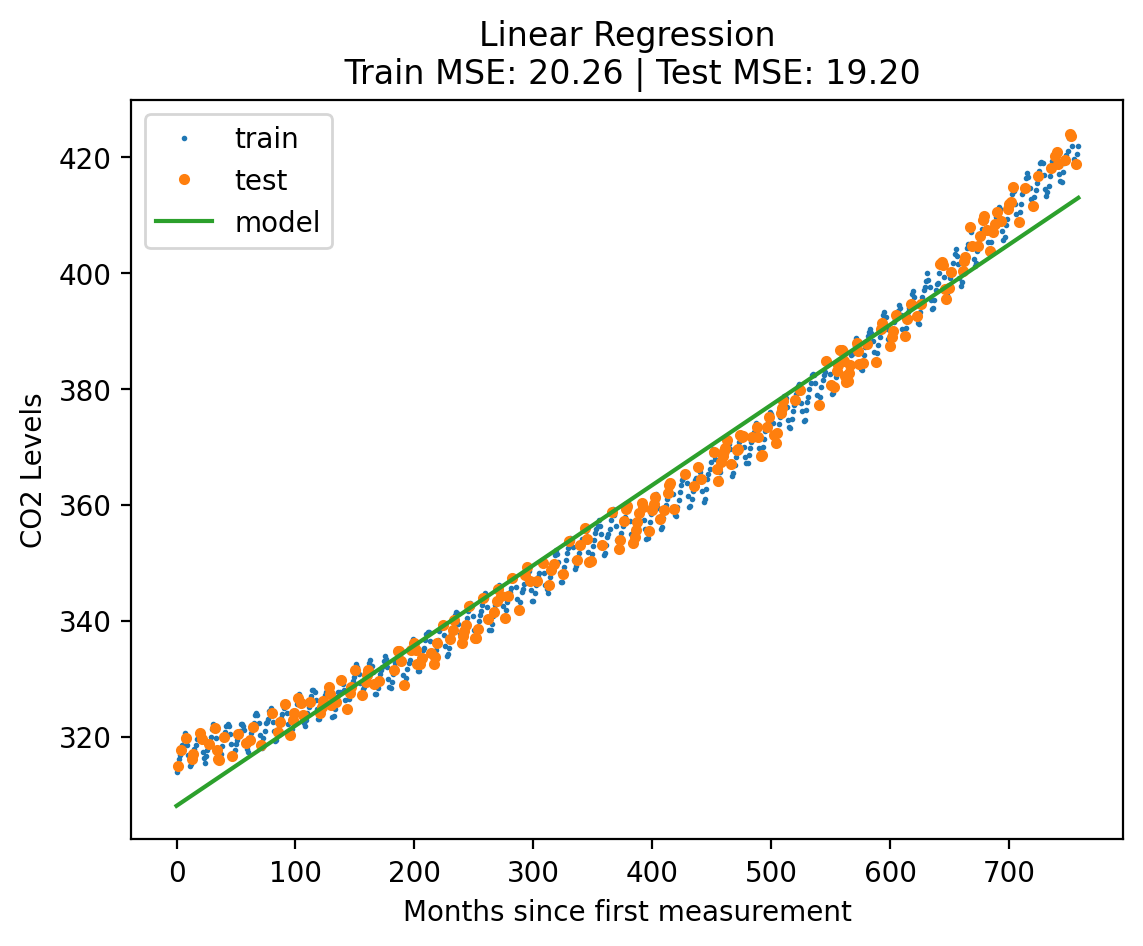

In [16]:
model = LinearRegression()
plot_fit_predict(model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "Linear Regression")

### MLP

c:\Users\ryees\anaconda3\envs\pml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'train': 4.752028323119785, 'test': 4.665698336426406}

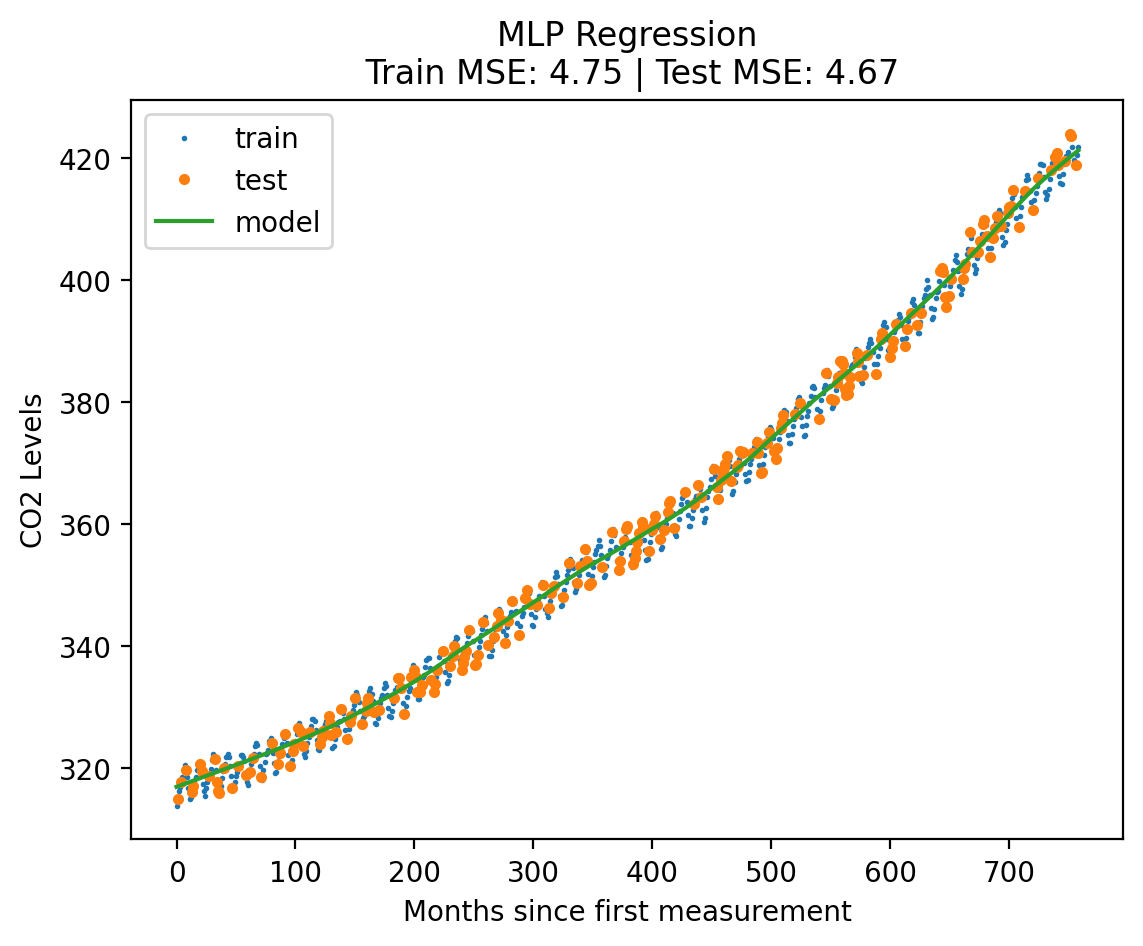

In [17]:
# use sk-learn for MLP
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter = 10000)

plot_fit_predict(mlp_model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "MLP Regression")

### Polynomial Regression of degree "d"

In [18]:
def create_poly_features(X, d):
    """
    X is (N, 1) array
    d is degree of polynomial
    returns normalized polynomial features of X
    """
    
    X_poly = np.zeros((len(X), d))
    for i in range(d):
        X_poly[:, i] = X[:, 0] ** (i + 1)
    
    # Normalize each column
    X_poly = StandardScaler().fit_transform(X_poly)
    return X_poly

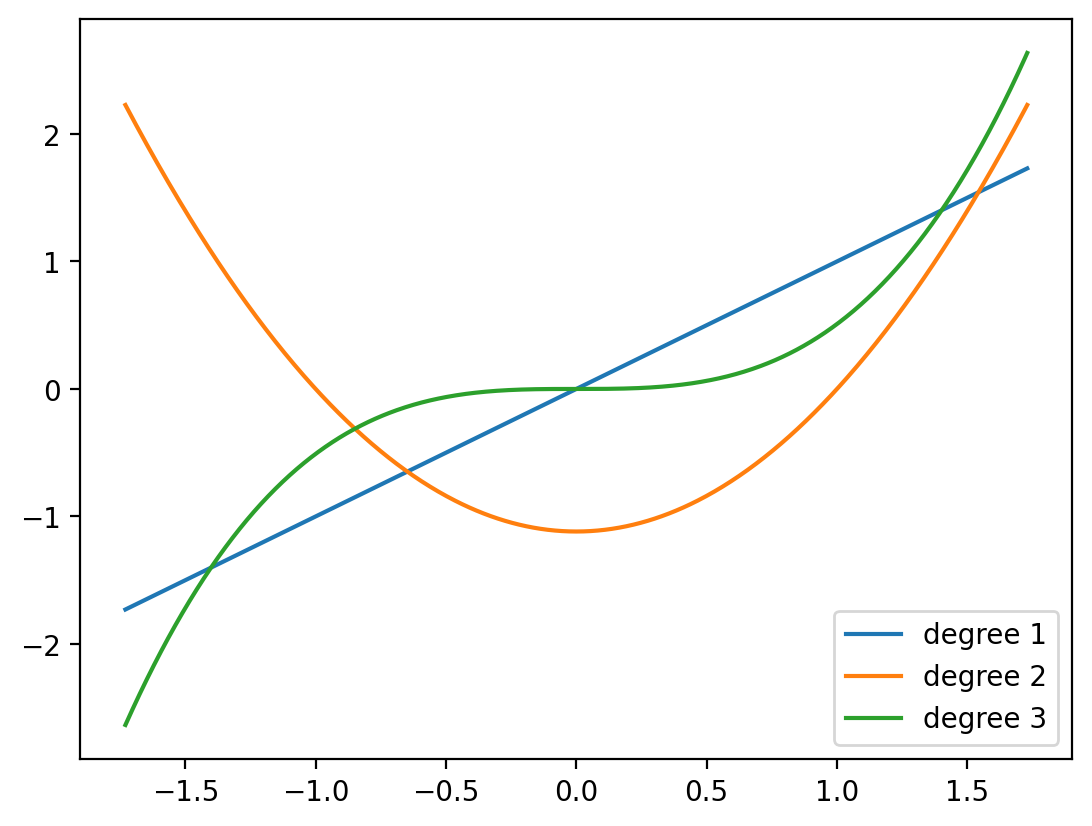

In [19]:
degree = 3
X_poly = create_poly_features(X_norm, degree)
for i in range(degree):
    plt.plot(X_norm, X_poly[:, i], label='degree {}'.format(i + 1))
plt.legend()

{'train': 4.956984807734837, 'test': 6.3743420617353355}

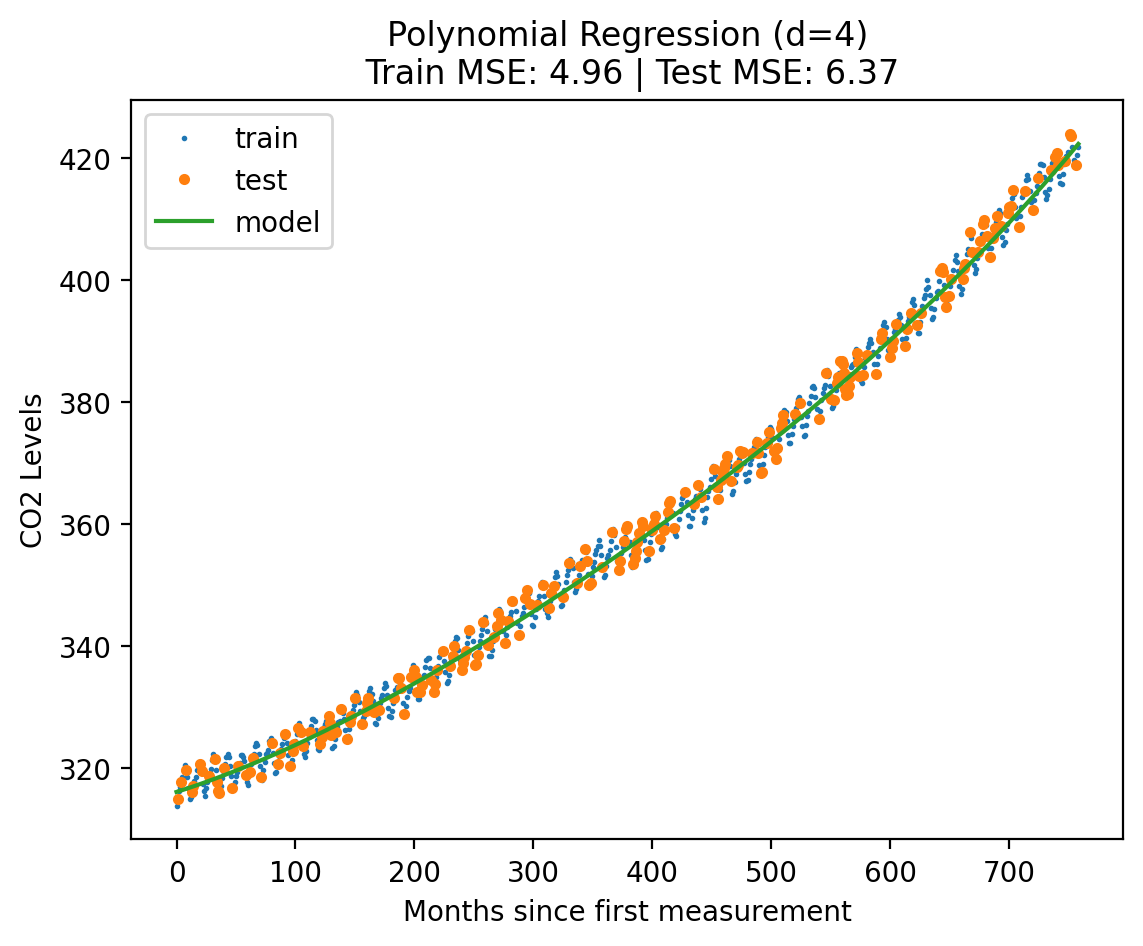

In [20]:
model2 = LinearRegression()
degree = 4
Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)
X_lin_poly = create_poly_features(X_lin_1d, degree)

plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Polynomial Regression (d={degree})")

In [21]:
model2.coef_, model2.intercept_

(array([[0.97834069, 0.09963612, 0.01969948, 0.0283343 ]]),
 array([-0.01122412]))

In [22]:
for degree in range(1, 10):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Polynomial Regression (d={degree})", plot=False)

In [23]:
errors_df = pd.DataFrame(errors).T
errors_df

,train,test
Linear Regression,20.261366,19.199722
MLP Regression,4.752028,4.665698
Polynomial Regression (d=4),4.956985,6.374342
Polynomial Regression (d=1),20.261366,20.851623
Polynomial Regression (d=2),5.075907,6.678665
Polynomial Regression (d=3),5.017752,6.567621
Polynomial Regression (d=5),4.816000,6.407422
Polynomial Regression (d=6),4.805097,6.390612
Polynomial Regression (d=7),4.767340,6.491631
Polynomial Regression (d=8),4.750171,6.508795


<Axes: title={'center': 'MSE for Train and Test Sets'}>

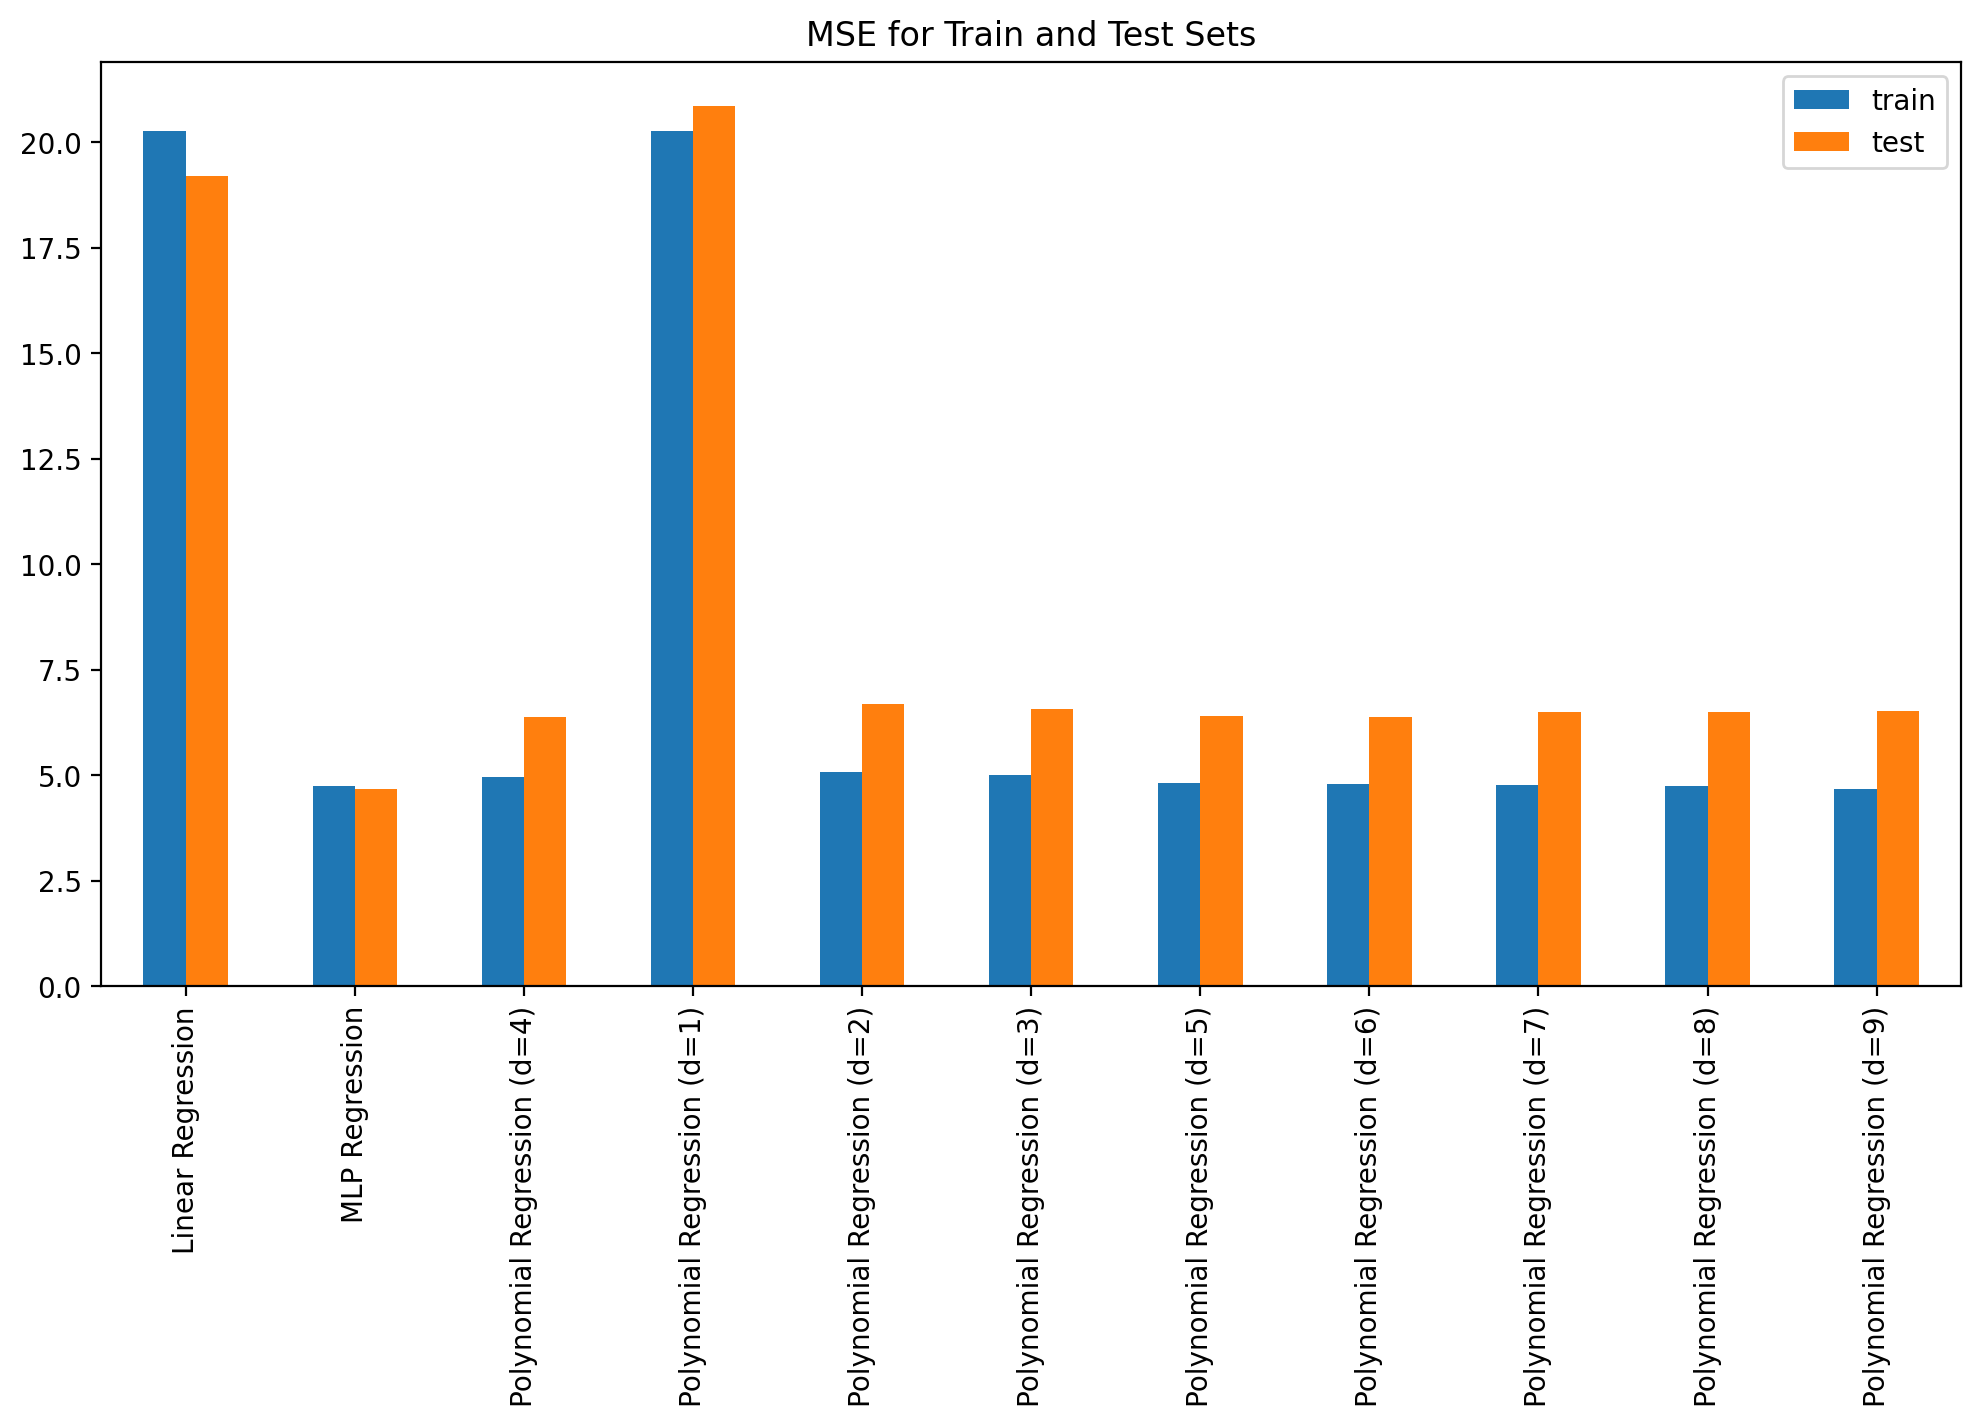

In [24]:
errors_df.plot(kind='bar', figsize=(12, 6), title='MSE for Train and Test Sets')

In [53]:
# bias variance tradeoff

errors_poly = {}

for degree in range(1, 20):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, degree, plot=False)

    # geting errors for polynomial regression only for plotting
    errors_poly[degree] = errors[degree]

Best degree: 4, Min error: 6.567621493533479


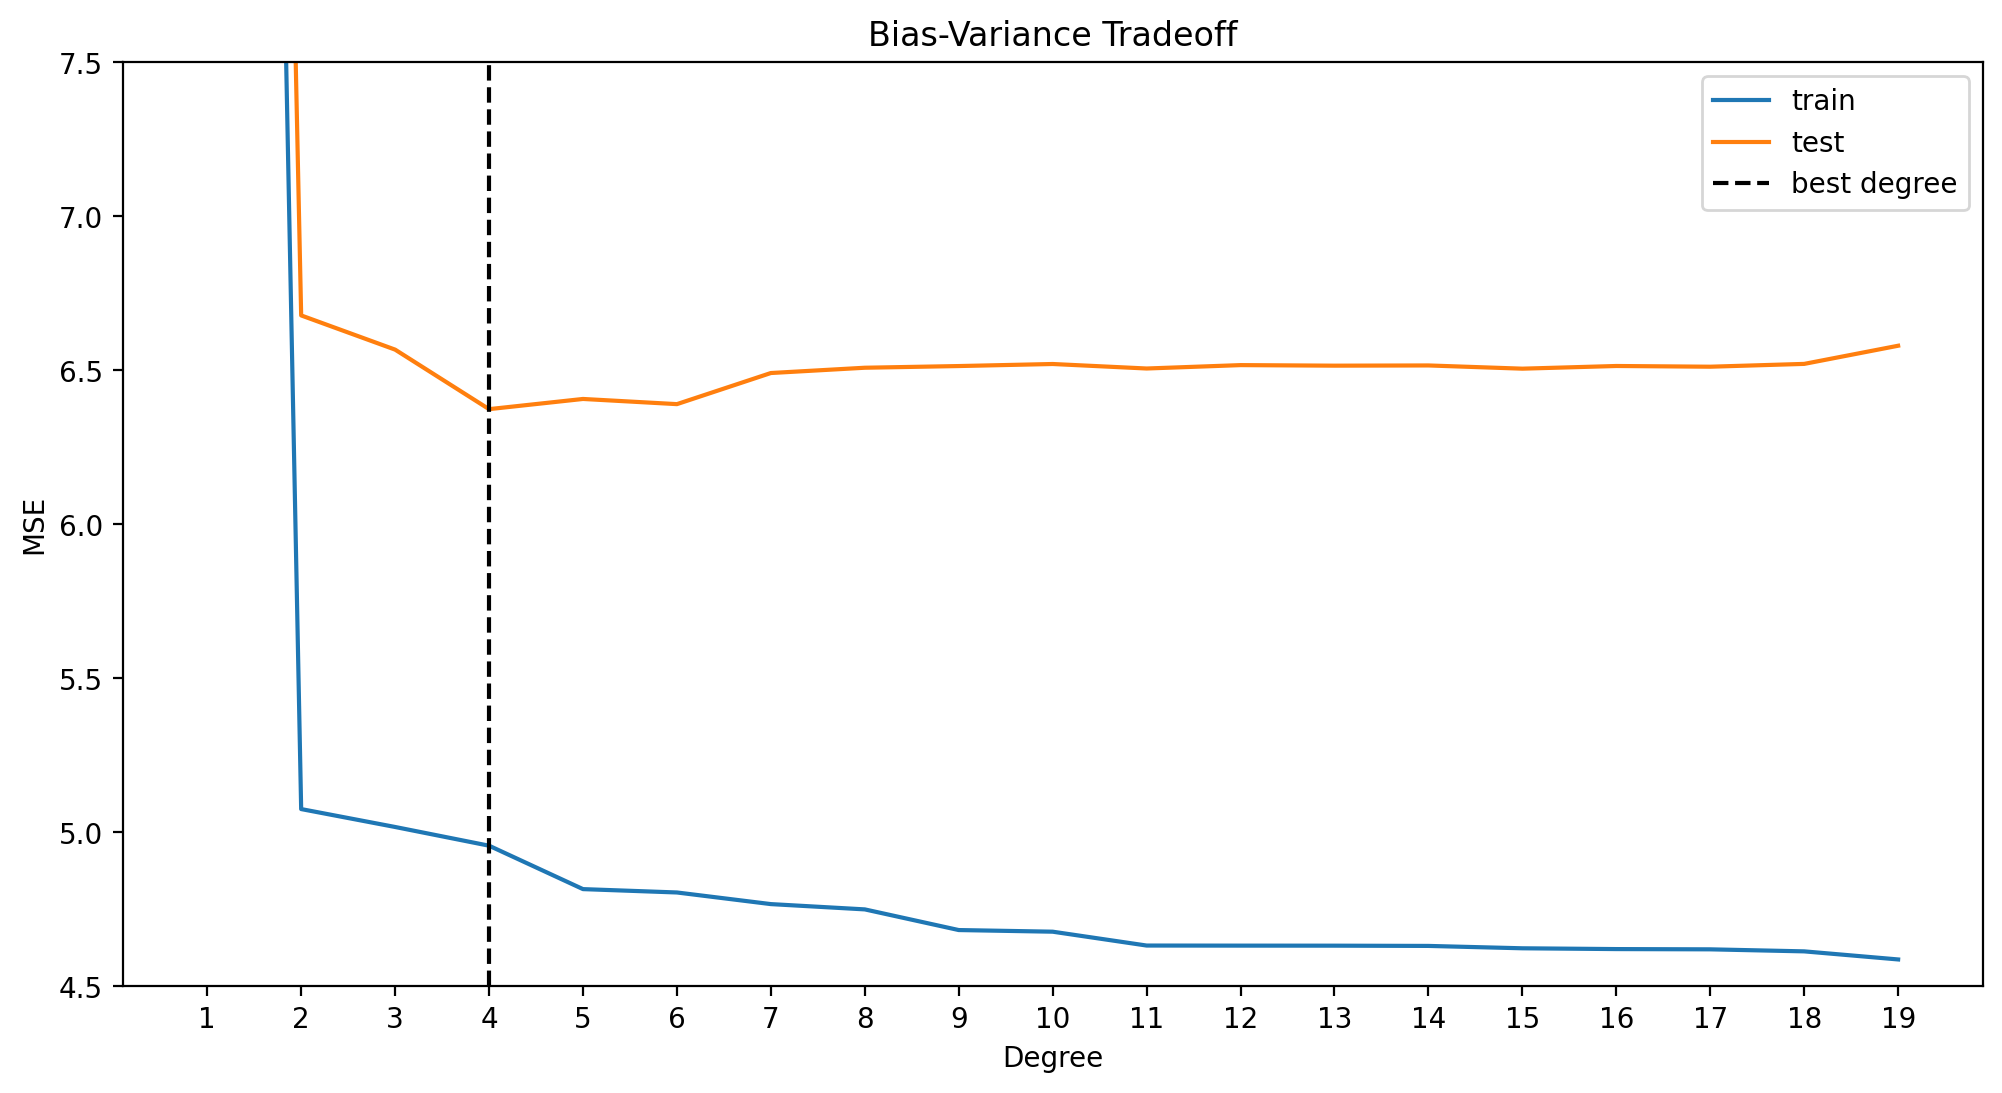

In [57]:
errors_poly_df = pd.DataFrame(errors_poly).T
best_degree = np.argmin(errors_poly_df.test) + 1
min_error = errors_poly_df.test[best_degree - 1]    # index of df = degree - 1
print(f"Best degree: {best_degree}, Min error: {min_error}")

# set figure size
plt.figure(figsize=(12, 6))
plt.plot(errors_poly_df.index, errors_poly_df.train, label='train')
plt.plot(errors_poly_df.index, errors_poly_df.test, label='test')
plt.axvline(best_degree, color='black', linestyle='--', label='best degree')
plt.xticks(np.arange(min(errors_poly_df.index), max(errors_poly_df.index)+1, 1.0))
plt.ylim(4.5, 7.5)      # set y limit - to show the difference between train and test clearly
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

In [101]:
# plot for successively adding polynomial features to show how close we get to train

degree = 8
X_poly = create_poly_features(X_norm, degree)
model3 = LinearRegression()
Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)
X_lin_poly = create_poly_features(X_lin_1d, degree)
plot_fit_predict(model3, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Succesively adding polynomial features", plot=False)

{'train': 4.750171469190134, 'test': 6.508794709125091}

In [102]:
model3.coef_, model3.intercept_

(array([[ 0.90185654,  0.1300646 ,  0.34425478, -0.16754834, -0.42642036,
          0.35487396,  0.17341507, -0.19121703]]),
 array([-0.01122412]))

In [103]:
# create a new array having model3.intercept_ as first element and model3.coef_ as rest of the elements
params = np.concatenate((model3.intercept_, model3.coef_.flatten())).reshape(-1, 1)
params

array([[-0.01122412],
       [ 0.90185654],
       [ 0.1300646 ],
       [ 0.34425478],
       [-0.16754834],
       [-0.42642036],
       [ 0.35487396],
       [ 0.17341507],
       [-0.19121703]])

In [104]:
# pad ones at the beginning of Xf_norm_train and Xf_norm_test to make them compatible with params
Xf_norm_train_padded = np.concatenate((np.ones((len(Xf_norm_train), 1)), Xf_norm_train), axis=1)
Xf_norm_test_padded = np.concatenate((np.ones((len(Xf_norm_test), 1)), Xf_norm_test), axis=1)
X_lin_poly_padded = np.concatenate((np.ones((len(X_lin_poly), 1)), X_lin_poly), axis=1)

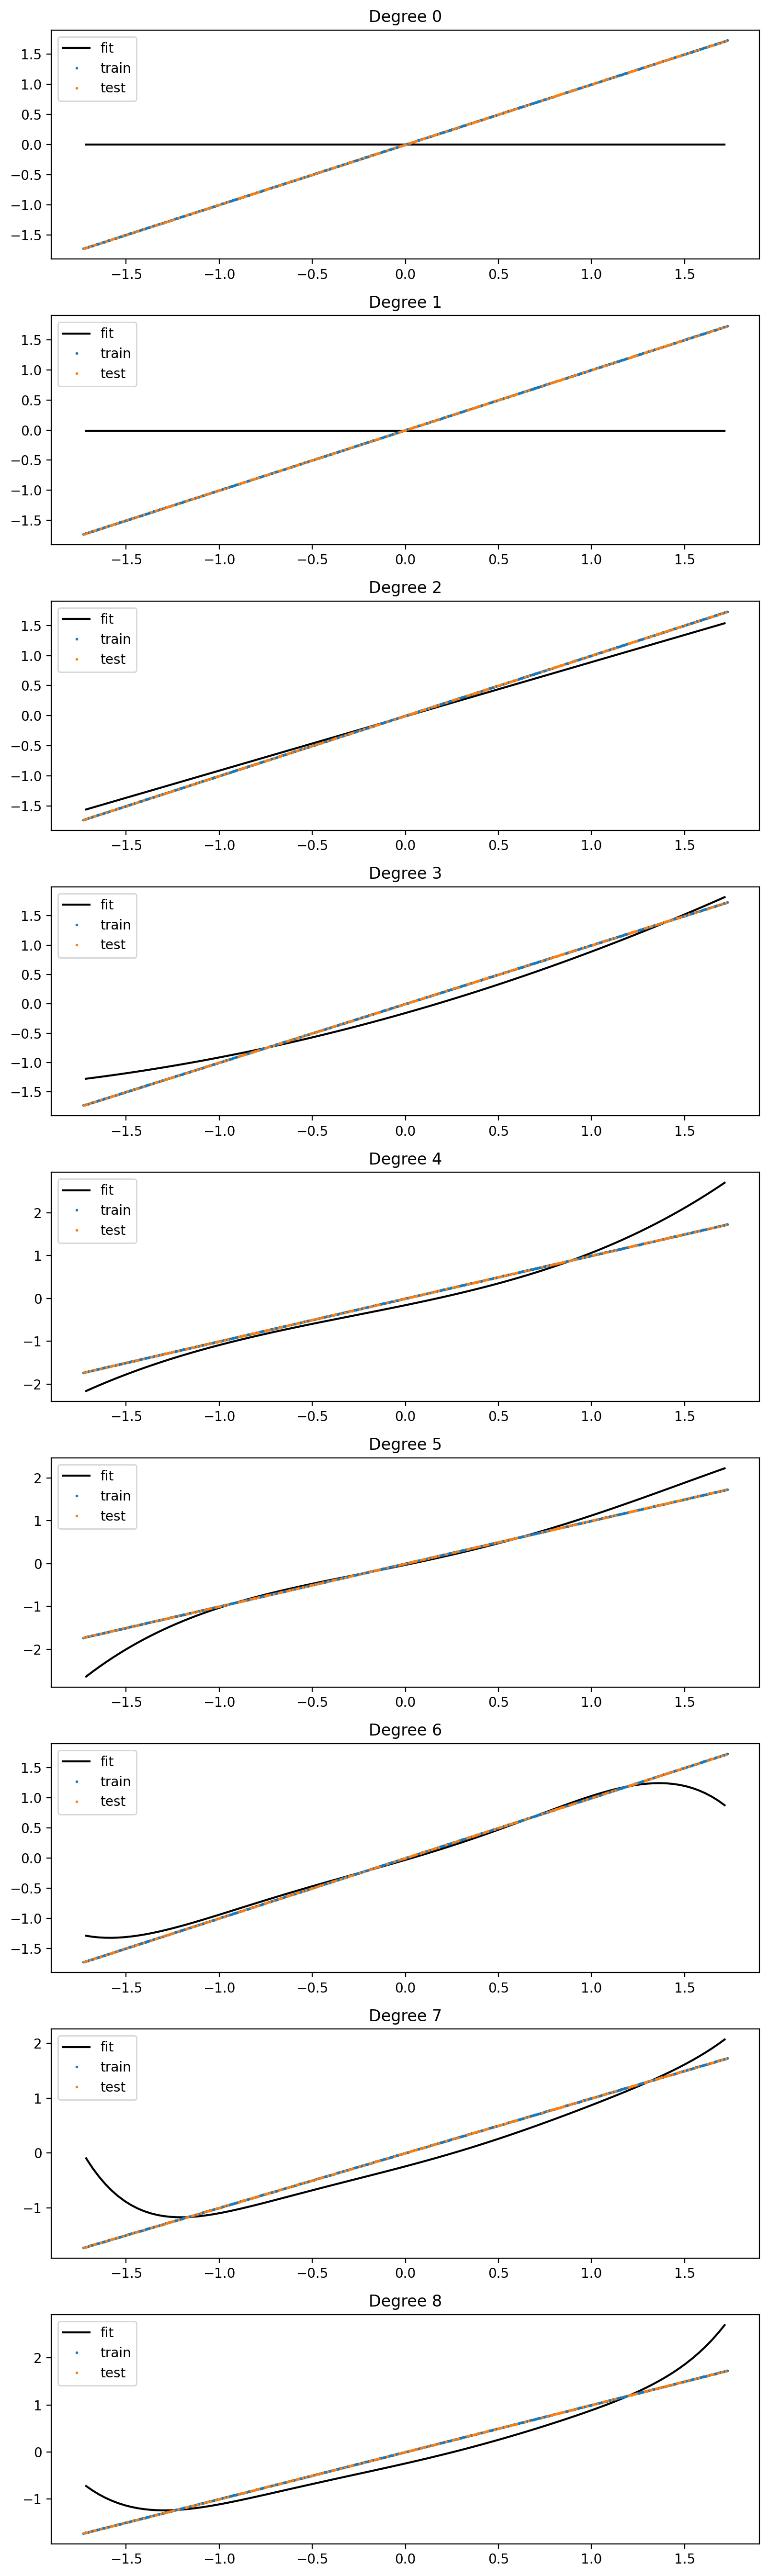

In [107]:
# create a plot consisting of 4 subplots to show how the model fits the data as we add more polynomial features
fig, axes = plt.subplots(degree+1, 1, figsize=(8, (degree+1)*3))
for i in range(0, degree+1):
    axes[i].plot(X_lin_poly_padded[:, 1], np.matmul(X_lin_poly_padded[:, :i], params[:i, :]), label='fit', color='black')
    axes[i].plot(X_norm_train, X_norm_train, 'o', label='train', markersize=1)
    axes[i].plot(X_norm_test, X_norm_test, 'o', label='test', ms=1)

    axes[i].set_title(f"Degree {i}")
    axes[i].legend()

plt.tight_layout()
plt.show()

### Fourier Features
Reference: https://bmild.github.io/fourfeat/

[ 0.99342831 -0.2765286 ]


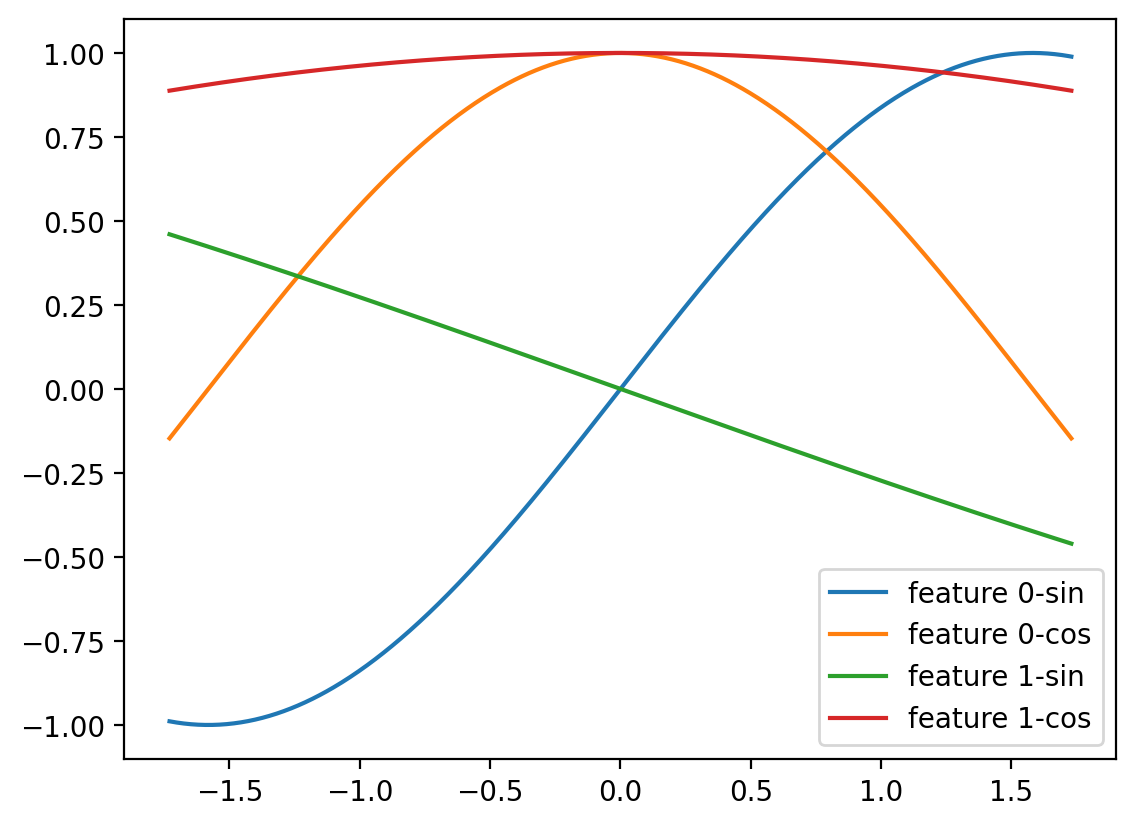

In [24]:
np.random.seed(42)
gamma = 2
NUM_features = 2
fs = gamma*np.random.randn(NUM_features)
print(fs)

for i in range(NUM_features):
    plt.plot(X_norm, np.sin(fs[i]*X_norm), label=f'feature {i}-sin')
    plt.plot(X_norm, np.cos(fs[i]*X_norm), label=f'feature {i}-cos')
plt.legend()

In [46]:
def create_random_features(X, gamma, NUM_features):
    """
    X is (N, 1) array
    gamma is a scalar
    NUM_features is a scalar
    """
    
    X_rff = np.zeros((len(X), 2*NUM_features + 1))
    X_rff[:, 0] = X[:, 0]
    for i in range(NUM_features):
        b = np.random.randn()
        X_rff[:, i+1] = np.sin(2*np.pi*gamma*b*X[:, 0])
        X_rff[:, i + NUM_features+1] = np.cos(2*np.pi*gamma*b*X[:, 0])
    
    # Normalize each column
    X_rff = StandardScaler().fit_transform(X_rff)
    return X_rff


In [57]:
X_lin_rff

array([[-1.71481604, -1.28417541, -0.38861298, -0.41824251,  1.26506668],
       [-1.68017329, -1.21596098, -0.20091393, -0.51803533,  1.3024362 ],
       [-1.64553055, -1.13907531, -0.00969706, -0.6120365 ,  1.31578663],
       [-1.6108878 , -1.05406667,  0.18168959, -0.69957566,  1.30488419],
       [-1.57624505, -0.96154129,  0.36989503, -0.78002855,  1.26991979],
       [-1.5416023 , -0.86215898,  0.55162396, -0.85282146,  1.21150562],
       [-1.50695955, -0.75662845,  0.72369448, -0.91743529,  1.13066445],
       [-1.4723168 , -0.64570226,  0.8830938 , -0.97340925,  1.02881174],
       [-1.43767406, -0.53017145,  1.02703099, -1.0203442 ,  0.90773083],
       [-1.40303131, -0.41085988,  1.15298584, -1.05790542,  0.76954172],
       [-1.36838856, -0.2886184 ,  1.25875301, -1.08582506,  0.616664  ],
       [-1.33374581, -0.16431873,  1.34248062, -1.10390403,  0.45177438],
       [-1.29910306, -0.03884727,  1.40270266, -1.11201339,  0.27775994],
       [-1.26446031,  0.08690122,  1.4

{'train': 5.02393338522299, 'test': 622.2419154098527}

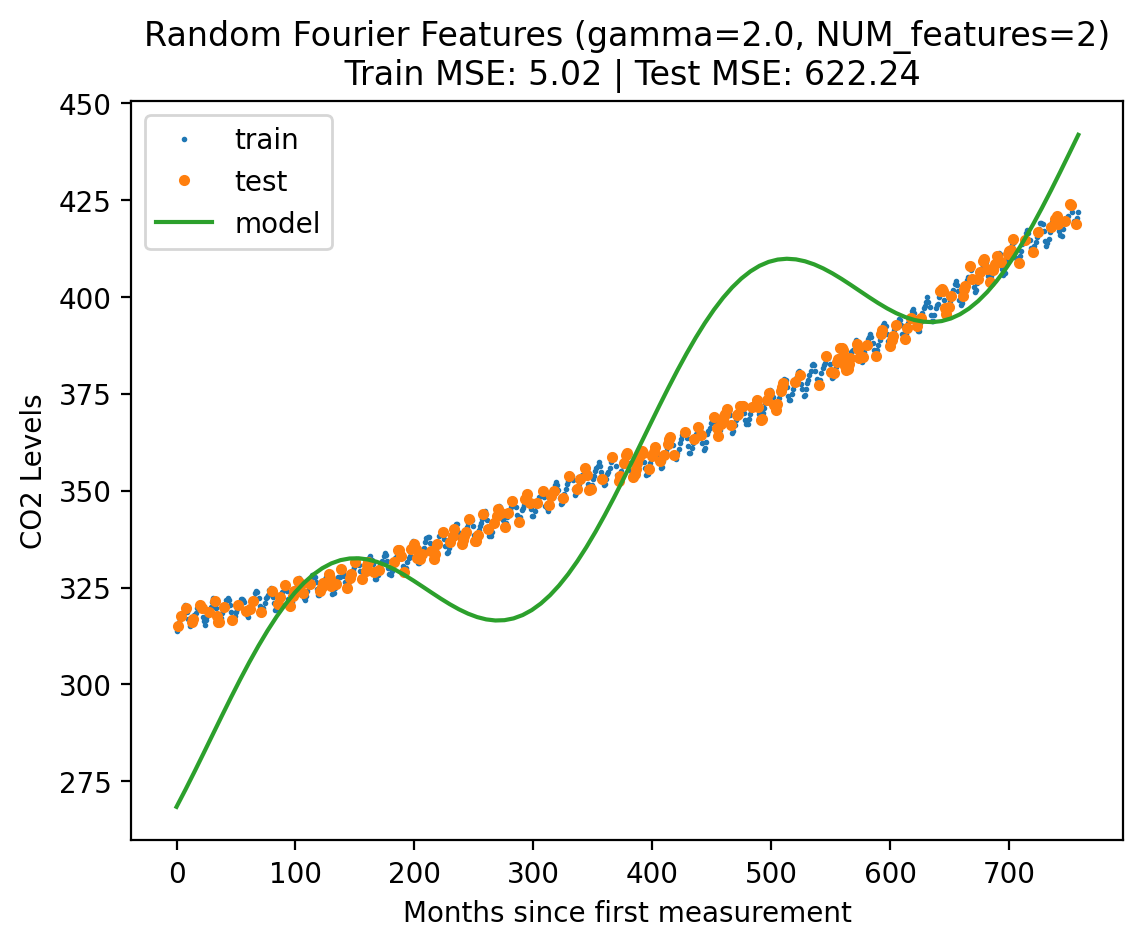

In [52]:
model3 = LinearRegression()
gamma = 2.0
NUM_features = 2

Xf_norm_train = create_random_features(X_norm_train.reshape(-1, 1), gamma, NUM_features)
Xf_norm_test = create_random_features(X_norm_test.reshape(-1, 1), gamma, NUM_features)

X_lin_rff = create_random_features(X_lin_1d, gamma, NUM_features)

plot_fit_predict(model3, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_rff, f"Random Fourier Features (gamma={gamma}, NUM_features={NUM_features})")

In [53]:
m = LinearRegression()
m.fit(Xf_norm_train, y_norm_train)

LinearRegression()

In [54]:
m.coef_, m.intercept_

(array([[ 1.52604646e+00, -1.05906347e-03,  5.29605437e-01,
          2.63571608e-03, -1.26872230e-01]]),
 array([-0.01122412]))

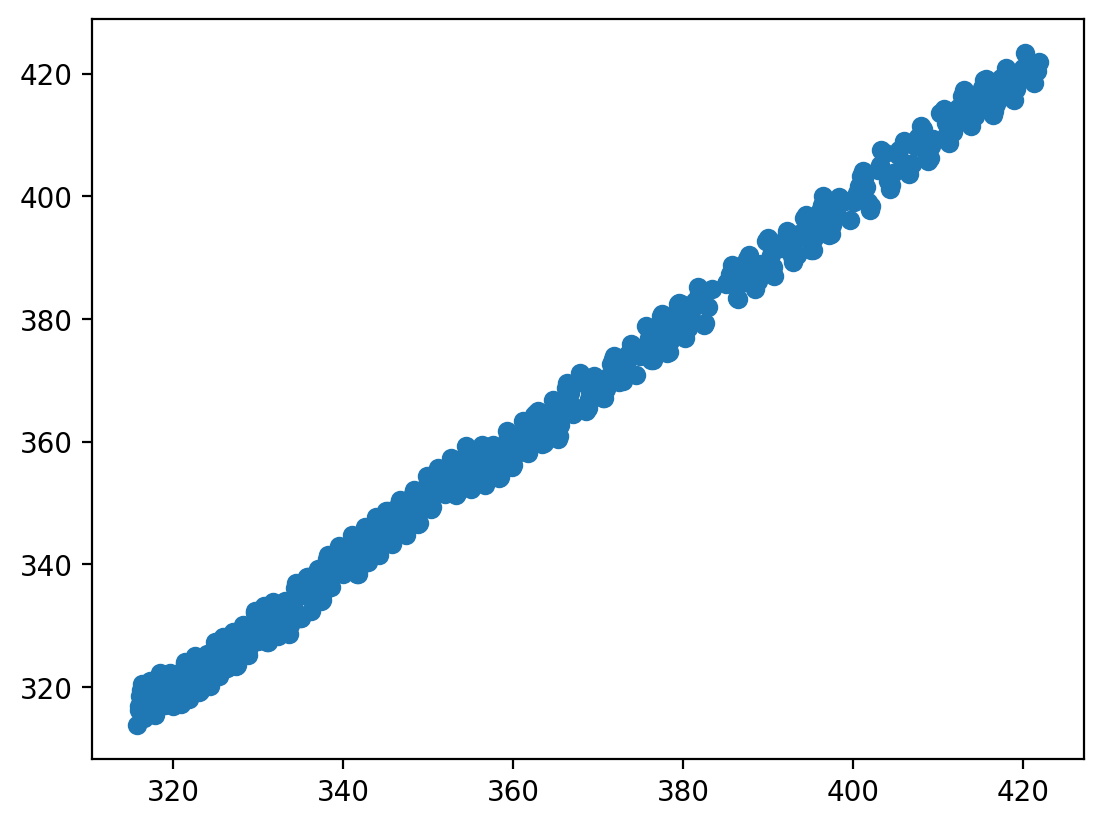

In [55]:
plt.scatter(s2.inverse_transform(m.predict(Xf_norm_train)), s2.inverse_transform(y_norm_train))

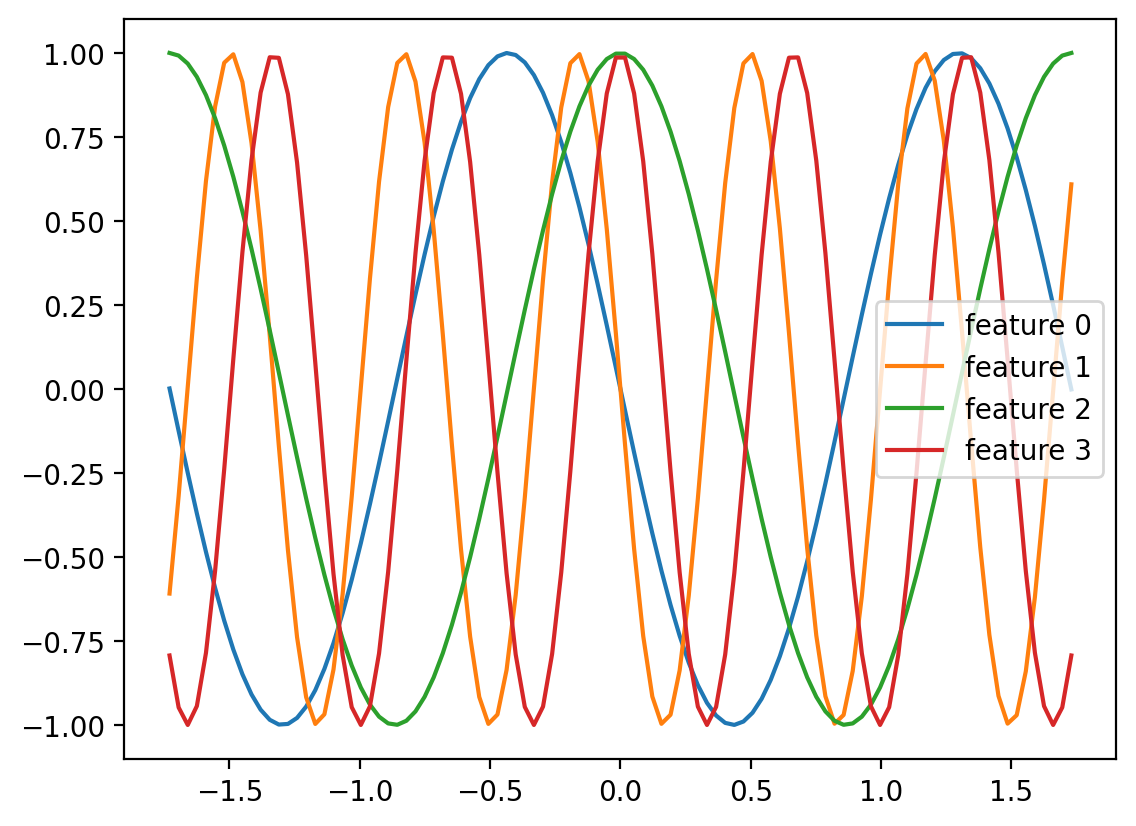

In [35]:
for i in range(2*NUM_features):
    plt.plot(X_lin_1d, X_lin_rff[:, i], label=f'feature {i}')
plt.legend()

In [36]:
pd.DataFrame(Xf_norm_train)

,0,1,2,3
0,-0.457724,0.384968,-0.889094,0.922930
1,-0.694043,-0.642098,0.719934,-0.766623
2,-0.292638,-0.994394,-0.956223,-0.105735
3,-0.005329,-0.551636,0.999986,-0.834085
4,0.914106,-0.973027,0.405475,0.230690
...,...,...,...,...
526,0.989959,0.626800,-0.141356,0.779180
527,-0.822347,-0.031144,0.568987,-0.999515
528,0.973425,0.989851,0.229005,0.142112
529,0.361822,0.896673,0.932247,0.442693


In [64]:
Xf_norm_train.mean(axis=0), Xf_norm_train.std(axis=0)

(array([ 0.0072727 ,  0.01224349, -0.00207386,  0.7155053 ,  0.98376132,
         0.80008136]),
 array([0.5179425 , 0.78034239, 0.15156346, 0.24234722, 0.01436464,
        0.17250117]))

In [65]:
X_lin_rff.mean(axis=0), X_lin_rff.std(axis=0)

(array([ 1.02695630e-17, -4.99600361e-17,  3.33066907e-17,  9.89284627e-01,
         9.96341528e-01, -1.69664336e-01]),
 array([0.68041538, 0.76569102, 0.69261351, 0.00956945, 0.00327021,
        0.7317483 ]))

### Before this...

# Dataset 1: Sine wave with noise

In [1]:
# Generate some data
rng = np.random.RandomState(1)
x = 15 * rng.rand(200)
y = np.sin(x) + 0.1 * rng.randn(200)
df = pd.DataFrame({'x': x, 'y': y})

# plot the data
plt.scatter(df.x, df.y)
plt.show()

NameError: name 'np' is not defined

In [2]:
# Train test split
train = df.sample(frac=0.8, random_state=1)
test = df.drop(train.index)

plt.scatter(train.x, train.y, color='blue', label='train')
plt.scatter(test.x, test.y, color='orange', label='test')
plt.legend()
plt.show()

NameError: name 'df' is not defined

In [3]:
def plot_predictions(train, test, yhat_train, yhat_test):
        
    # add yhat_train to train and yhat_test to test
    train['yhat'] = yhat_train
    test['yhat'] = yhat_test

    # sort train and test by x
    train = train.sort_values(by='x')
    test = test.sort_values(by='x')

    # Train and test error
    train_rmse = np.sqrt(np.mean((train.yhat - train.y)**2))
    test_rmse = np.sqrt(np.mean((test.yhat - test.y)**2))

    plt.scatter(train.x, train.y, color='blue', label='train')
    plt.scatter(test.x, test.y, color='orange', label='test')
    plt.plot(train.x, train.yhat, color='red', label='train prediction')
    plt.plot(test.x, test.yhat, color='green', label='test prediction')
    plt.title('Train RMSE: {:.3f}, Test RMSE: {:.3f}'.format(train_rmse, test_rmse))
    plt.legend()
    plt.show()

    return train_rmse, test_rmse

In [5]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
def hyperparameter_tuning(params, train, test, model):
    train_rmse = []
    test_rmse = []

    for d in params:
        yhat_train, yhat_test = model(d, train, test)
        train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
        test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

    plt.plot(params, train_rmse, label='train')
    plt.plot(params, test_rmse, label='test')
    plt.xlabel('params')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    optimal_param = params[np.argmin(test_rmse)]

    return optimal_param

In [6]:
rmse_dict = {}

### Model 1: MLP

In [7]:
# use sk-learn for MLP
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter = 10000)
mlp_model.fit(np.array(train.x).reshape(-1, 1), train.y)

MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter=10000)

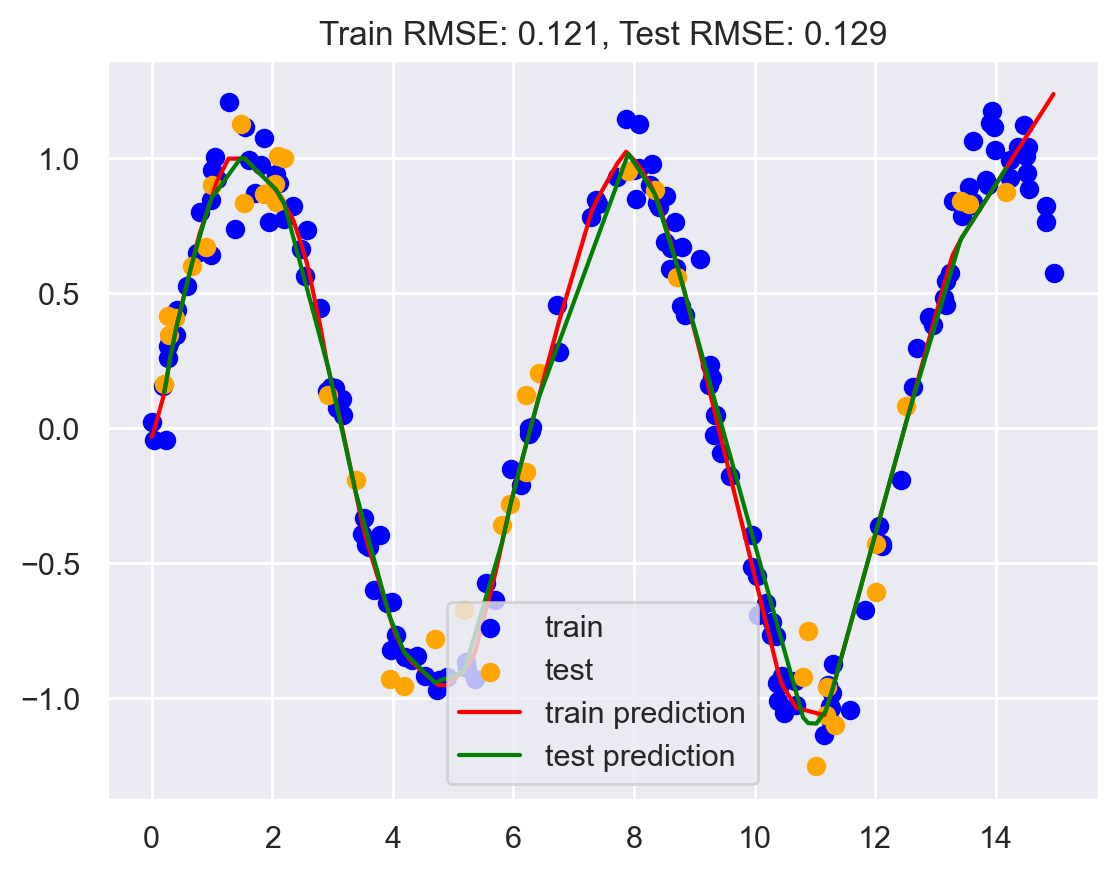

In [8]:
yhat_train = mlp_model.predict(np.array(train.x).reshape(-1, 1))
yhat_test = mlp_model.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['MLP'] = (train_rmse, test_rmse)

### Model 2: Vanilla Linear Regression

In [10]:
lr1 = LinearRegression()
lr1.fit(np.array(train.x).reshape(-1, 1), train.y)

LinearRegression()

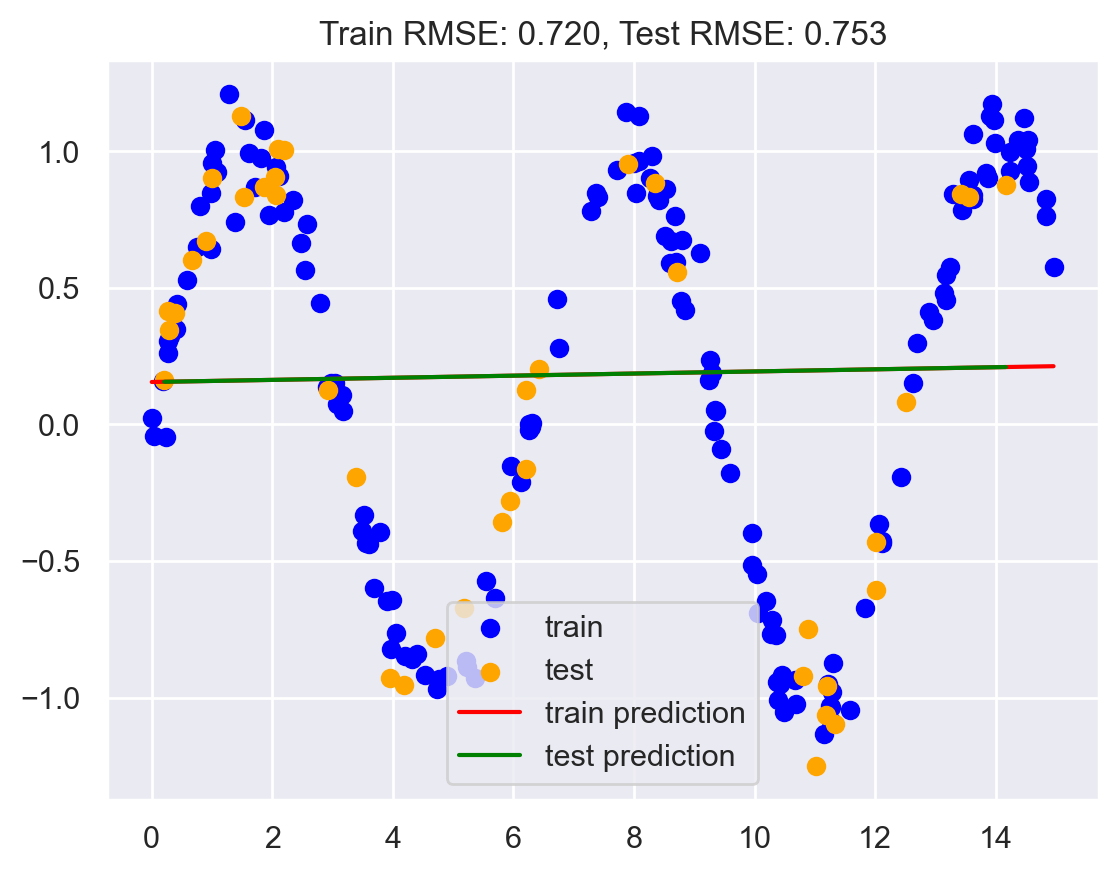

In [11]:
yhat_train = lr1.predict(np.array(train.x).reshape(-1, 1))
yhat_test = lr1.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Vanilla LR'] = (train_rmse, test_rmse)

### Model 3: Polynomial regression with degree d

In [12]:
def poly_regression(d, train, test):
    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    
    X_train = pf.fit_transform(train.x.values.reshape(-1, 1))
    X_test = pf.fit_transform(test.x.values.reshape(-1, 1))
    
    lr.fit(X_train, train.y)
    
    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

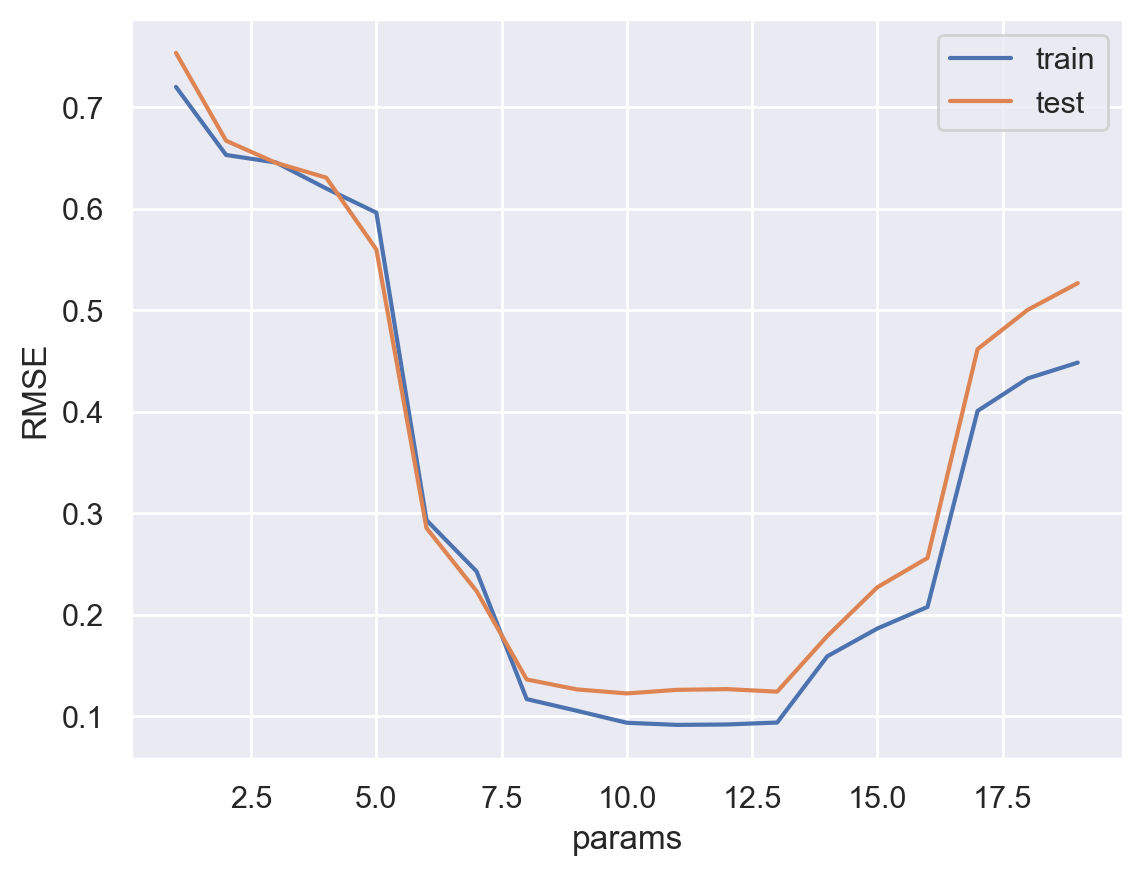

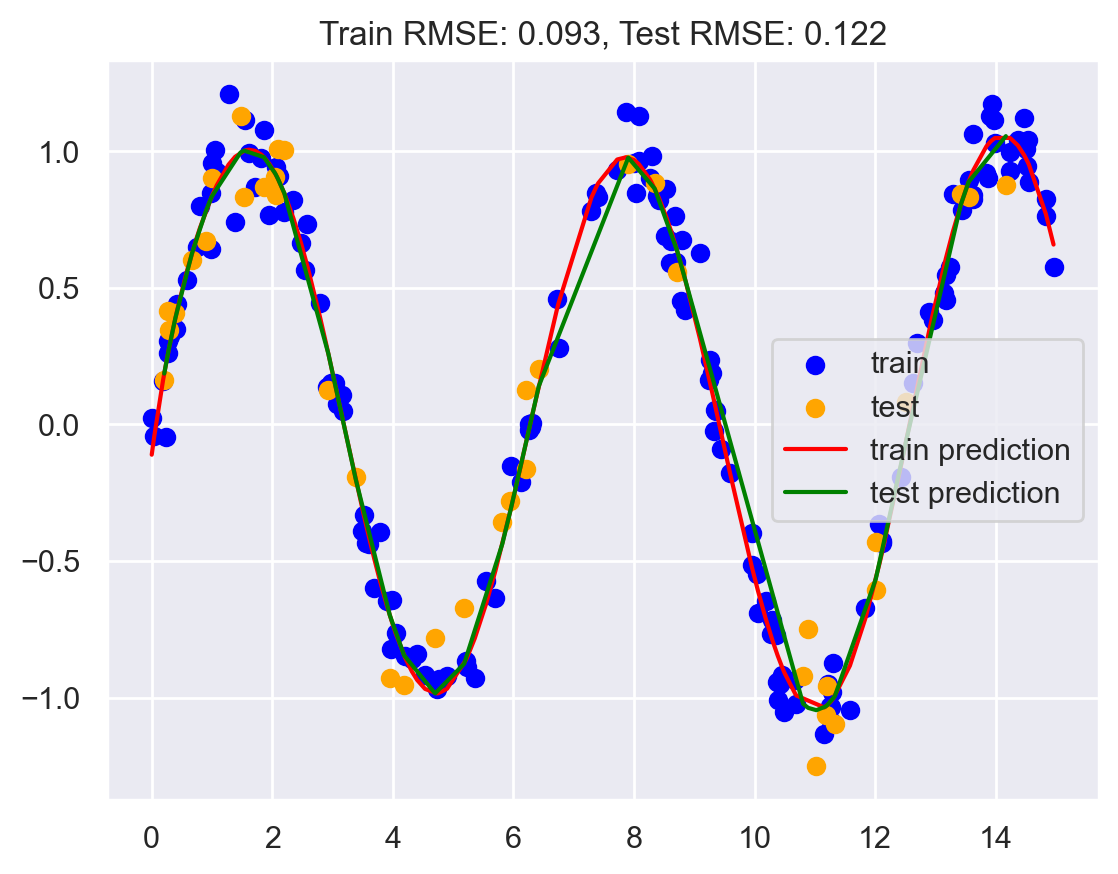

In [13]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
degrees = range(1, 20)
best_degree = hyperparameter_tuning(degrees, train, test, poly_regression)
yhat_train, yhat_test = poly_regression(best_degree, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Polynomial Regression'] = (train_rmse, test_rmse)
print("Best degree: ", best_degree)

### Model 4: Linear regression with sine and cosine basis functions

In [14]:
def sine_basis_regression(num_basis, train, test):
    lr = LinearRegression()
    for i in range(1, num_basis+1):
        train[f"sine_{i}"] = np.sin(i*train.x)
        train[f"cosine_{i}"] = np.cos(i*train.x)
        test[f"sine_{i}"] = np.sin(i*test.x)
        test[f"cosine_{i}"] = np.cos(i*test.x)
    
    X_train = train.drop(['y'], axis=1)
    X_test = test.drop(['y'], axis=1)
    
    lr.fit(X_train, train.y)

    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

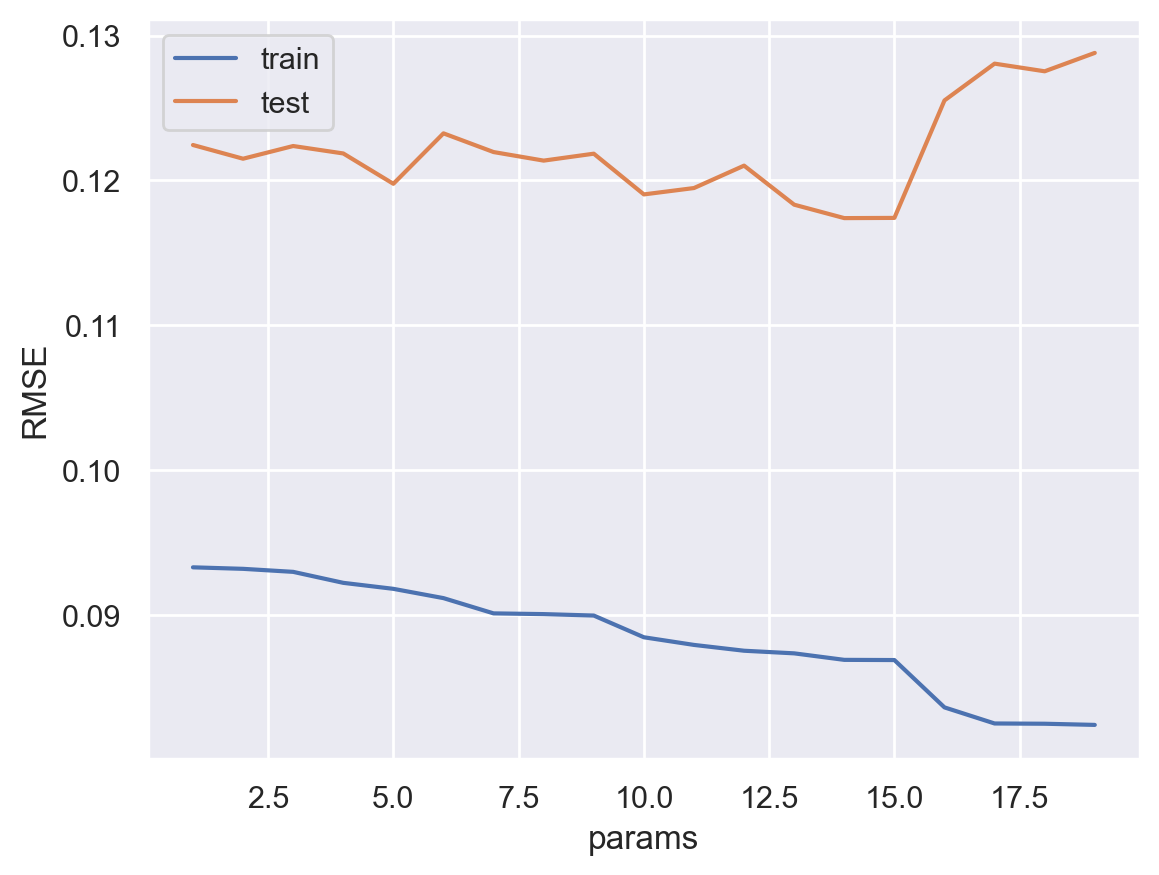

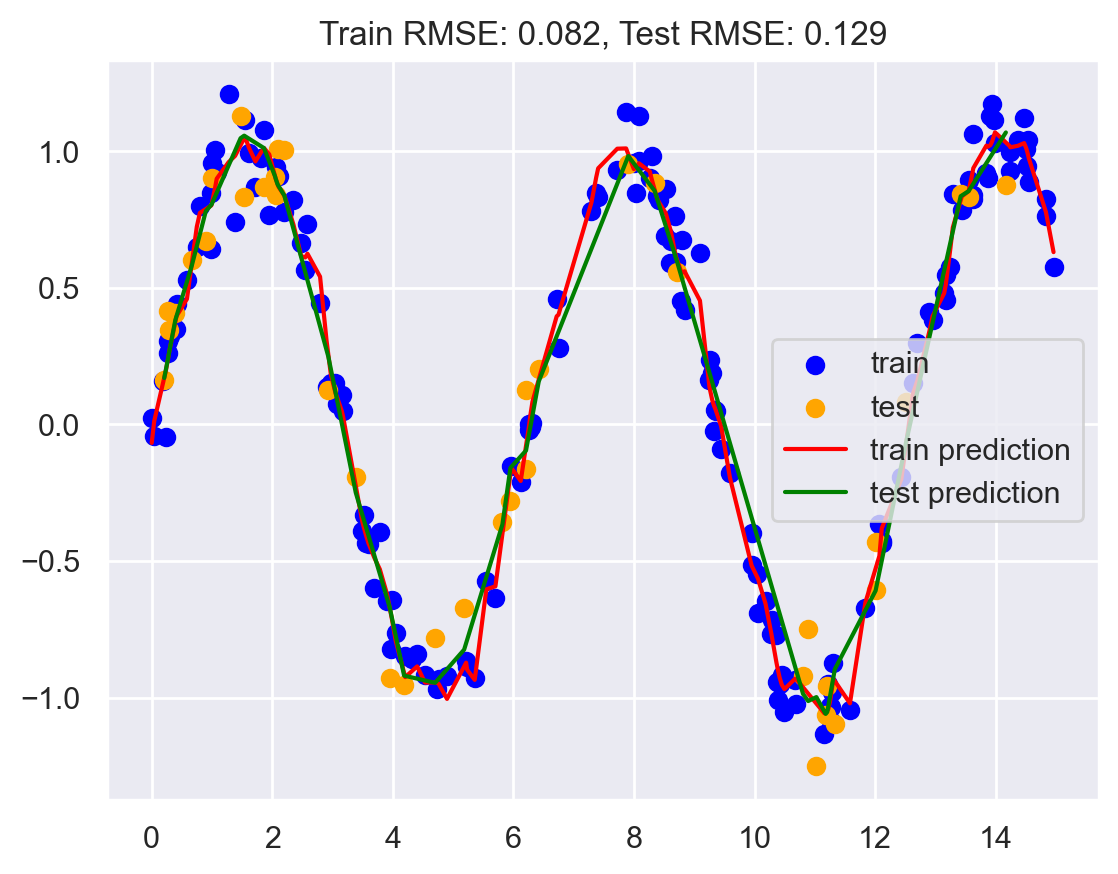

Best number of basis:  14


In [15]:
basis = range(1, 20)
best_num_basis = hyperparameter_tuning(basis, train, test, sine_basis_regression)
yhat_train, yhat_test = sine_basis_regression(best_num_basis, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Sine Basis Regression'] = (train_rmse, test_rmse)
print("Best number of basis: ", best_num_basis)

### Model 5: Linear regression with Gaussian basis functions

In [16]:
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Gaussian-basis-functions

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """
    Uniformly spaced Gaussian features for one-dimensional input
    
    Constructor with N centers and width_factor as hyperparameters
    N comes from the number of basis functions
    width_factor is the width of each basis function
    """
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

Best number of basis:  13


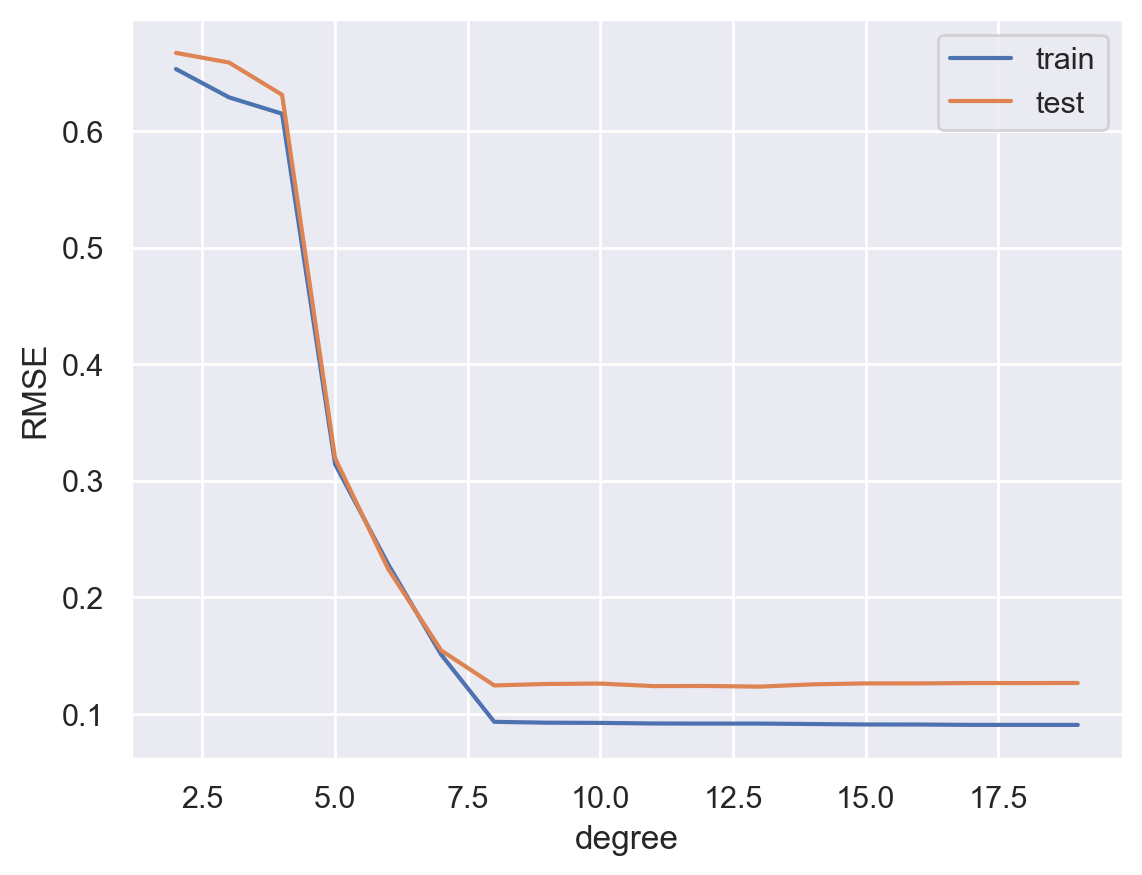

In [17]:
# Hyperparameter tuning
basis = range(2, 20)

train_rmse = []
test_rmse = []
for d in basis:
    model = make_pipeline(GaussianFeatures(d), LinearRegression())
    model.fit(np.array(train.x).reshape(-1, 1), train.y)
    yhat_train = model.predict(np.array(train.x).reshape(-1, 1))
    yhat_test = model.predict(np.array(test.x).reshape(-1, 1))
    train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
    test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

best_num_basis = basis[np.argmin(test_rmse)]
print("Best number of basis: ", best_num_basis)
plt.plot(basis, train_rmse, label='train')
plt.plot(basis, test_rmse, label='test')
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

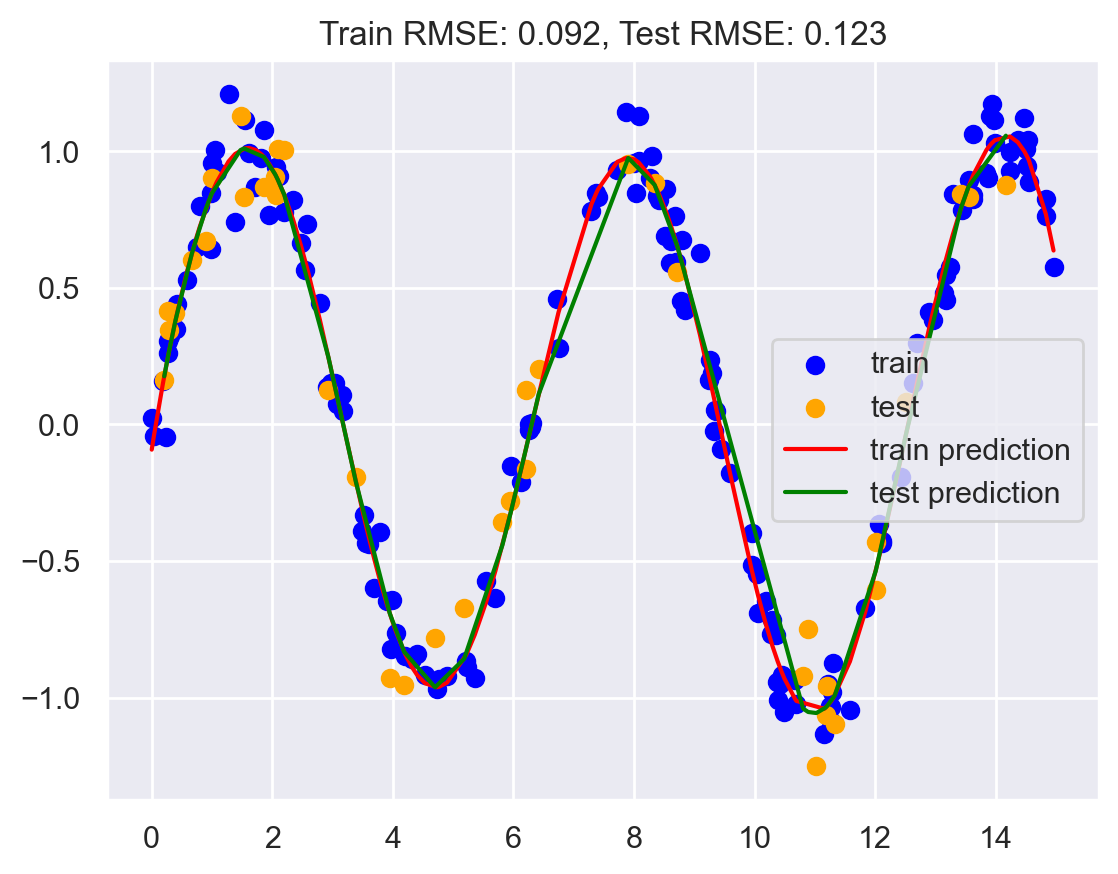

In [18]:
gauss_model = make_pipeline(GaussianFeatures(best_num_basis), LinearRegression())
gauss_model.fit(np.array(train.x).reshape(-1, 1), train.y)
yhat_train = gauss_model.predict(train.x.values.reshape(-1, 1))
yhat_test = gauss_model.predict(test.x.values.reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Gaussian Basis Regression'] = (train_rmse, test_rmse)

#### Plotting rmse using different variants of linear regression

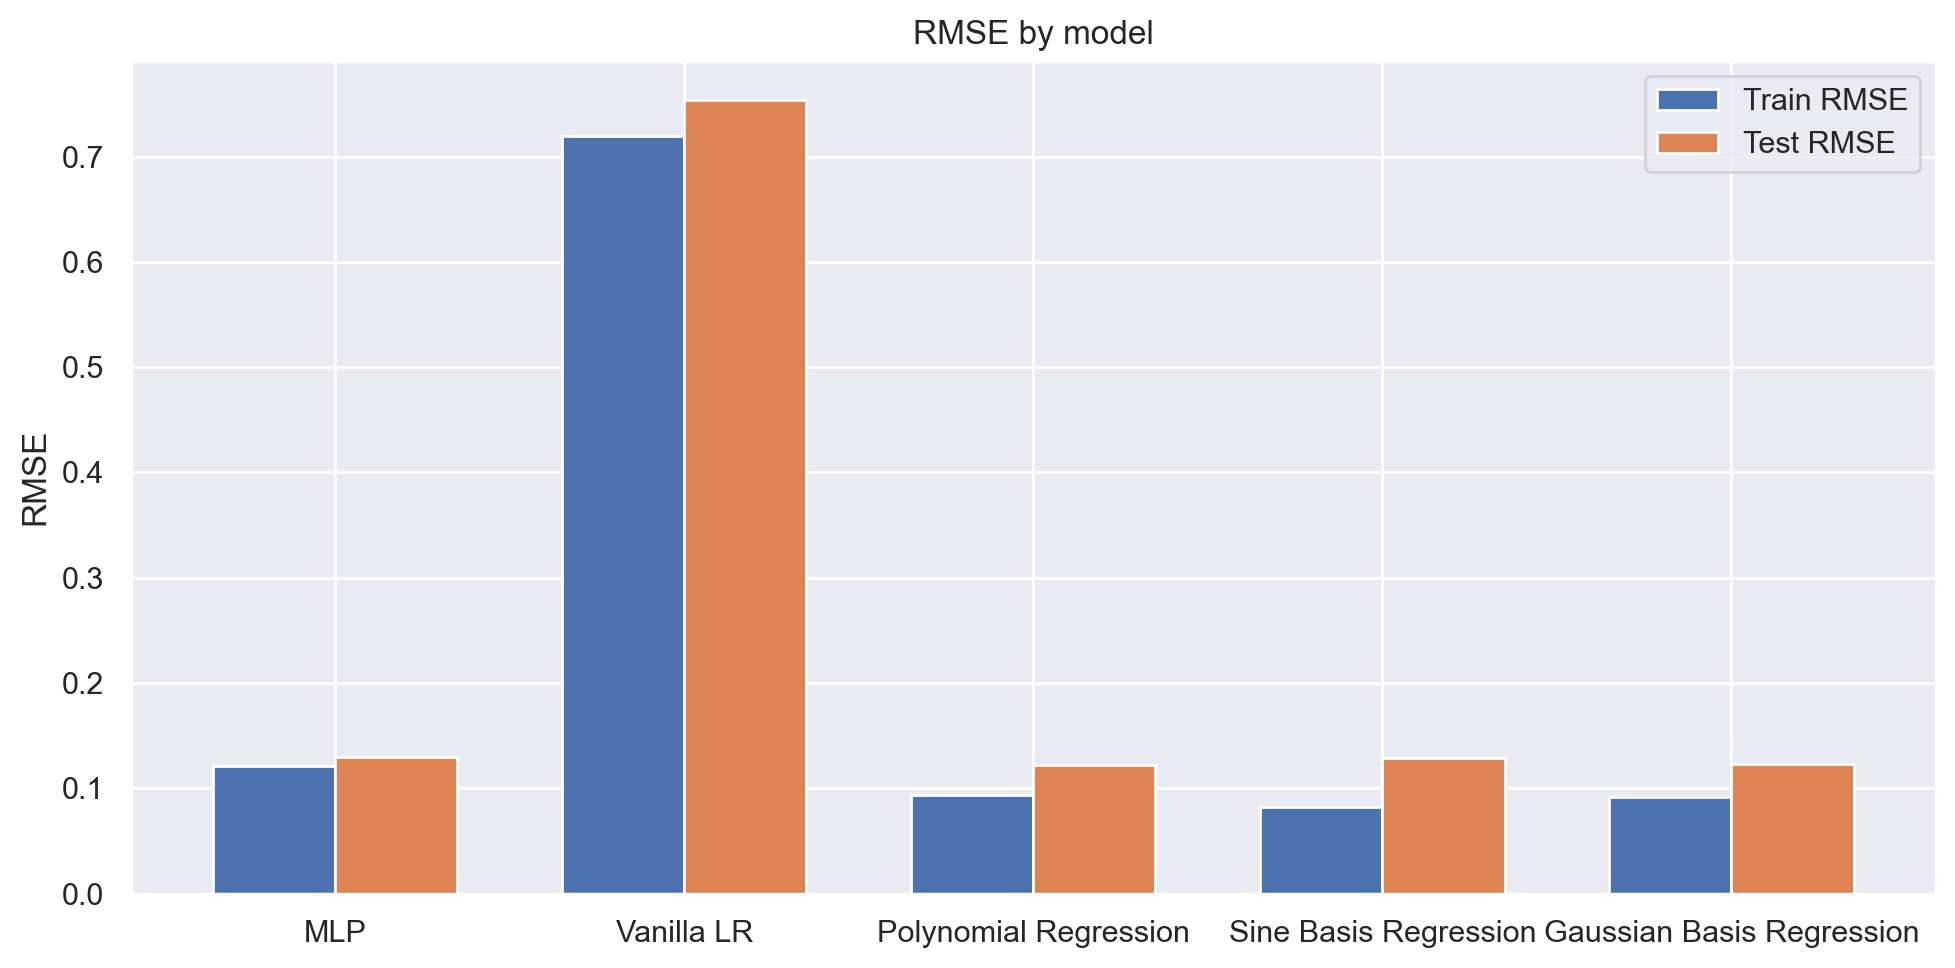

In [21]:
# create a bar plot of train and test RMSE

train_rmse = [rmse_dict[key][0] for key in rmse_dict.keys()]
test_rmse = [rmse_dict[key][1] for key in rmse_dict.keys()]
labels = [key for key in rmse_dict.keys()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
rects2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

# Dataset 2: CO2 Dataset

In [ ]:
df

In [ ]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [ ]:
df

In [ ]:
df.average.plot()

In [ ]:
train_cutoff = 2000
train = df[df.year < train_cutoff]
test = df[df.year >= train_cutoff]
df.average.plot()

train.average.plot(color='blue')
test.average.plot(color='orange')

len(train), len(test)

In [ ]:
months_from_start = range(len(df))
months_from_start = np.array(months_from_start).reshape(-1, 1)

In [ ]:
# use sk-learn for MLP

mlp_model = MLPRegressor(hidden_layer_sizes=[512, 512, 512, 512, 512], max_iter = 5000)
mlp_model.fit(months_from_start[:len(train)], train.average.values)

In [ ]:
yhat_train = mlp_model.predict(months_from_start[:len(train)])
yhat_test = mlp_model.predict(months_from_start[len(train):])

yhat_train = pd.Series(yhat_train, index=train.index)
yhat_test = pd.Series(yhat_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
# normalize data

train_scaled = (train - train.mean()) / train.std()
test_scaled = (test - test.mean()) / test.std()
months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

# train_scaled = (train - train.mean()) / train.std()
# test_scaled = (test - test.mean()) / test.std()
# months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

mlp_model = MLPRegressor(hidden_layer_sizes=512, max_iter = 1000)
mlp_model.fit(months_from_start_scaled[:len(train)], train_scaled.average.values)

yhat_train = mlp_model.predict(months_from_start_scaled[:len(train)])
yhat_test = mlp_model.predict(months_from_start_scaled[len(train):])

yhat_train_scaled = pd.Series(yhat_train, index=train.index)
yhat_test_scaled = pd.Series(yhat_test, index=test.index)

yhat_train = yhat_train_scaled * train.std() + train.mean()
# yhat_test = yhat_test_scaled * test.std() + test.mean()


df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 2: Vanilla Linear Regression

In [ ]:
lr1 = LinearRegression()
lr1.fit(months_from_start[:len(train)], train.average.values)
yhat1_test = lr1.predict(months_from_start[len(train):])
yhat1_train = lr1.predict(months_from_start[:len(train)])

yhat_train = pd.Series(yhat1_train, index=train.index)
yhat_test = pd.Series(yhat1_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 3: Polynomial regression with degree d

In [ ]:
def poly_regression(d, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    X_train = pf.fit_transform(months_from_start[:len(train)])
    X_test = pf.fit_transform(months_from_start[len(train):])
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    df.average.plot()
    yhat_train.plot()
    yhat_test.plot()
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_regression(2, train, test)

### Model 4: Linear Regression with sine and cosine basis functions

In [ ]:
### Adding sine and cosine terms
def sine_cosine_features(X, n):
    """
    X: array of shape (n_samples, 1)
    n: number of sine and cosine features to add
    """
    for i in range(1, n+1):
        X = np.hstack([X, np.sin(i*X), np.cos(i*X)])
    return X

In [ ]:
X = np.linspace(-1, 1, 100).reshape(-1, 1)

In [ ]:
_ = plt.plot(X, sine_cosine_features(X, 0))

### Model 5: Gaussian basis functions

### Model 6: Linear Regression with polynomial and sine/cosine basis functions

In [ ]:
def poly_sine_cosine_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = sine_cosine_features(months_from_start[:len(train)], n)
    
    X_test = sine_cosine_features(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_sine_cosine_regression(6, train, test)

### Model 7: Random Fourier Features

In [ ]:
def rff_featurise(X, n_components=100):
    # Random Fourier Features
    # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
    from sklearn.kernel_approximation import RBFSampler
    rbf_feature = RBFSampler(gamma=1, n_components=n_components, random_state=1)
    X_features = rbf_feature.fit_transform(X)
    return X_features

In [ ]:
def poly_rff_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = rff_featurise(months_from_start[:len(train)], n)
    
    X_test = rff_featurise(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_rff_regression(440, train, test)